In [1]:
import argparse
#import six.cPickle as cPickle
import os
import sys
import torch
import rdkit
import numpy as np
#import warnings
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import scipy

from chemprop.parsing import parse_predict_args
from chemprop.train import make_predictions
from chemprop.parsing import add_predict_args
from chemprop.parsing import modify_predict_args
from rdkit import Chem
from rdkit.Chem import AllChem
from molvs import Standardizer
from molvs import validate_smiles
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import RandomizedPCA
import sklearn.feature_extraction
from rdkit.Chem.Fingerprints import FingerprintMols


In [2]:
%sh
/databricks/python/bin/pip install molsets
find /databricks/python/lib/python3.6/site-packages/moses/ -type f -print0 | xargs -0 sed -i 's/from\ rdkit.six.moves\ import\ cPickle/import\ _pickle\ as\ cPickle/g'

Collecting molsets
 Downloading https://files.pythonhosted.org/packages/d2/69/07e97e29998f9a0ef43ae3f9767faaaeec0c1e3b92796a57185574d4ef03/molsets-0.1.3-py3-none-any.whl (6.0MB)
Requirement already satisfied: numpy>=1.15 in /databricks/python3/lib/python3.6/site-packages (from molsets) (1.16.4)
Requirement already satisfied: pandas>=0.23 in /databricks/python3/lib/python3.6/site-packages (from molsets) (0.25.0)
Collecting torch>=1.0.1 (from molsets)
 Downloading https://files.pythonhosted.org/packages/30/57/d5cceb0799c06733eefce80c395459f28970ebb9e896846ce96ab579a3f1/torch-1.2.0-cp36-cp36m-manylinux1_x86_64.whl (748.8MB)
Requirement already satisfied: matplotlib>=3.0.0 in /databricks/python3/lib/python3.6/site-packages (from molsets) (3.0.3)
Requirement already satisfied: scipy>=1.1.0 in /databricks/python3/lib/python3.6/site-packages (from molsets) (1.1.0)
Requirement already satisfied: tqdm>=4.26.0 in /databricks/python3/lib/python3.6/site-packages (from molsets) (4.35.0)
Requirement already satisfied: seaborn in /databricks/python3/lib/python3.6/site-packages (from molsets) (0.8.1)
Collecting fcd-torch>=1.0.5 (from molsets)
 Downloading https://files.pythonhosted.org/packages/48/45/476df503cd87d28486af12c37b2e71fc5d0b2730f9bd0539cf19782678b8/fcd_torch-1.0.7-py3-none-any.whl (5.2MB)
Requirement already satisfied: pytz>=2017.2 in /databricks/python3/lib/python3.6/site-packages (from pandas>=0.23->molsets) (2019.2)
Requirement already satisfied: python-dateutil>=2.6.1 in /databricks/python3/lib/python3.6/site-packages (from pandas>=0.23->molsets) (2.8.0)
Requirement already satisfied: cycler>=0.10 in /databricks/python3/lib/python3.6/site-packages (from matplotlib>=3.0.0->molsets) (0.10.0)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.6/site-packages (from matplotlib>=3.0.0->molsets) (1.0.1)
Requirement already satisfied: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /databricks/python3/lib/python3.6/site-packages (from matplotlib>=3.0.0->molsets) (2.2.0)
Requirement already satisfied: six>=1.5 in /databricks/python3/lib/python3.6/site-packages (from python-dateutil>=2.6.1->pandas>=0.23->molsets) (1.12.0)
Requirement already satisfied: setuptools in /databricks/python3/lib/python3.6/site-packages (from kiwisolver>=1.0.1->matplotlib>=3.0.0->molsets) (41.0.1)
Installing collected packages: torch, fcd-torch, molsets
 Found existing installation: torch 0.4.1
 Uninstalling torch-0.4.1:
 Successfully uninstalled torch-0.4.1
Successfully installed fcd-torch-1.0.7 molsets-0.1.3 torch-1.2.0

In [3]:
import moses
from moses.script_utils import add_train_args, read_smiles_csv, set_seed, add_sample_args
from moses.models_storage import ModelsStorage
from moses.metrics.metrics import get_all_metrics
from tqdm import tqdm
from moses.metrics import FrechetMetric, NP, weight, logP, SA, QED
from moses.metrics.utils import get_mol, mapper
from moses.utils import disable_rdkit_log

# Variables

In [5]:
%run /Users/vxjdk@leo-pharma.com/mol_utils

In [6]:

datasets = ["Homopiperazines","Piperazines","Piperidines","Sulphamides"]
names = ["JAK1 EC50 nM 1027","JAK2 EC50 nM 1024","JAK3 EC50 nM 1026"]
names = names + ['TYK2 EC50 nM 1025']
files = ["/dbfs/FileStore/tables/Homopiperazines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Piperazines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Piperidines_cleaned_Feb_2019.sdf",
         "/dbfs/FileStore/tables/Sulphamides_cleaned_Feb_2019.sdf",
        ]
PARENT_DIR = '/dbfs/FileStore/tables'
PICKLES_DIR = '/dbfs/FileStore/pickles'
MOSES_DIR = '/dbfs/FileStore/moses'
CHEMPROP_DIR = '/dbfs/FileStore/chemprop'
ZINC_DIR = '/dbfs/FileStore/ZINC'
ZINC_Models = os.path.join(ZINC_DIR,'models')
VIRTUAL_SCREENING = os.path.join(ZINC_DIR,'virtual_screening')
models = ['aae','char_rnn']
targets = ['JAK1','JAK2','JAK3','TYK2']

In [7]:
from molvs import Validator
from tqdm import tqdm
tqdm.pandas(desc="Progress")
def calculate_feature(descriptor, df, out_feat, out_smi = None):
  validator = Validator()
  

  print('Generated:',len(df))
  df = df.drop_duplicates()
  print('Unique:',len(df))
  df['Molecules'] = df.SMILES.apply(lambda smi: Chem.MolFromSmiles(smi))
  
  df = df.dropna(subset=['Molecules'])
  print('Molecules:',len(df))
  prop = []
  for mol in df['Molecules']:
    try:
      prop.append(descriptor(mol))
    except:
      prop.append(None)
  df[str(descriptor)] = prop
  df = df.dropna(subset=[str(descriptor)])
  print('Valid Molecules:',len(df))
  df[str(descriptor)].to_csv(out_feat,index=False)
  df.SMILES.to_csv(out_smi, index=False)
def plot_pca(models, X_train, model_smiles):
  f, axes = plt.subplots(1, len(models), sharex = True, sharey=True, figsize=(len(models)*3,3))
  for i, name in enumerate(models):

    gen = [Chem.MolFromSmiles(smi) for smi in model_smiles[name]]
    train_num = len(X_train)
    all_fps = [Chem.MolFromSmiles(smi) for smi in X_train] + gen
    fps = get_fps(all_fps, morgan=True)

    v = sklearn.feature_extraction.DictVectorizer(sparse=True, dtype=float)
    v.fit(fps)
    print(len(v.feature_names_))
    print(len(v.vocabulary_))

    X = v.transform(fps)

    X = X.toarray()


    scaler = StandardScaler(copy=False)
    scaler.fit(X[:train_num])
    scaler.transform(X)

    print(len(X))
    print(train_num)

    pca = RandomizedPCA(n_components=3,random_state=13)
    pca.fit(X[:train_num])

    Xred =pca.transform(X)
    ax=axes[i]
    ax.scatter(Xred[train_num:,0], Xred[train_num:,1],1,'r',marker='o')
    ax.scatter(Xred[:train_num,0], Xred[:train_num,1],1,'b',marker='.')
    
    ax.set_title(name)
  f.tight_layout()
  display(f)

# Preparing different seeds

In [9]:
val = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','val-182_bin76.csv'))
test = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','test-183_bin76.csv'))
all_bin = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','train-1460_bin76.csv'))
all_bin = all_bin.append(val)
all_bin = all_bin.append(test)
print(all_bin.shape)
print(all_bin.columns)
for col in all_bin.columns[1:]:
  
  all_bin[all_bin[col]==1].filter(['smiles']).rename(columns={'smiles':'SMILES'}).to_csv(os.path.join(VIRTUAL_SCREENING,col+'_actives.smi'),index=None)
  all_bin[all_bin[col]==1].filter(['smiles']).rename(columns={'smiles':'SMILES'}).sample(n=100, random_state=13).to_csv(os.path.join(VIRTUAL_SCREENING,col+'_100actives.smi'),index=None)
  all_bin[all_bin[col]==0].filter(['smiles']).rename(columns={'smiles':'SMILES'}).sample(n=100, random_state=13).to_csv(os.path.join(VIRTUAL_SCREENING,col+'_100inactives.smi'),index=None)

(1825, 5)
Index(['smiles', 'JAK1', 'JAK2', 'JAK3', 'TYK2'], dtype='object')

In [10]:

all_bin = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','train-1460_bin76.csv'))

print(all_bin.shape)
for col in all_bin.columns[1:]:
  print(len(all_bin[all_bin[col]==1]))

(1460, 5)
717
653
240
94

In [11]:

val = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','val-182_bin76.csv'))
test = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','test-183_bin76.csv'))
all_bin = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all_2188-sparse-regression.csv'))
print(all_bin.shape)
all_bin = all_bin[~all_bin.smiles.isin(val.smiles)]
all_bin = all_bin[~all_bin.smiles.isin(test.smiles)]
print(all_bin.shape)
print(all_bin.columns)
for col in all_bin.columns[1:]:
  actives = all_bin[all_bin[col]>7.6].filter(['smiles']).rename(columns={'smiles':'SMILES'})
  actives.to_csv(os.path.join(VIRTUAL_SCREENING,col+'_actives-train.smi'),index=None)
  print(len(actives))
  all_bin[all_bin[col]>7.6].filter(['smiles']).rename(columns={'smiles':'SMILES'}).sample(n=92, random_state=13).to_csv(os.path.join(VIRTUAL_SCREENING,col+'_100actives-train.smi'),index=None)

(2188, 5)
(1816, 5)
Index(['smiles', 'JAK1', 'JAK2', 'JAK3', 'TYK2'], dtype='object')
753
705
244
92

In [12]:
all_bin = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all_2188-sparse-regression.csv'))
train_bin = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','train-1460_bin76.csv'))
all_bin = all_bin[~all_bin.smiles.isin(train_bin.smiles)]
for col in all_bin.columns[1:]:
  actives = all_bin[all_bin[col]>7.6].filter(['smiles']).rename(columns={'smiles':'SMILES'})
  actives.to_csv(os.path.join(VIRTUAL_SCREENING,col+'_actives-nontrain.smi'),index=None)
  print(len(actives))

204
207
63
19

# Testing epoch number

In [14]:
#Check how much epochs needed to train char-rnn and aae to reach plateau
from mordred import SLogP, Calculator
ITERATIONS = 31
n = 1
n_samples = '300'
targets = ['JAK1','JAK2','JAK3','TYK2']
VS_Models = os.path.join(VIRTUAL_SCREENING,'models')
for model in models:
  
  for target in targets:
    train_load = os.path.join(VIRTUAL_SCREENING,target+'_actives.smi')
    model_state = os.path.join(ZINC_Models,model+'-13t09-filt.model')
    config_load = os.path.join(ZINC_Models,model+'-13t09-filt.config')
    vocab_load = os.path.join(ZINC_Models,model+'-13t09-filt.vocab')
    for i in range(ITERATIONS):
      # Generating
      gen_save = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt_gen'+n_samples+'_vs'+target+'-iter'+str(i)+'x1e50epochTest.smi')
      MODELS = ModelsStorage()
      gen_parser = moses_parser_generate()
      config = gen_parser.parse_args([model,'--model_load',model_state,
                                      '--config_load',config_load,
                                      '--vocab_load',vocab_load,
                                      '--n_samples',n_samples,
                                      '--gen_save',gen_save])
      moses_generate(model,config)

      #prediction
      preds_path = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt_gen'+n_samples+'_vs'+target+'-iter'+str(i)+'x1e50epochTest-preds.csv')
      checkpoint_path = os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext','fold_0/model_0/model.pt')

      pred_parser = ArgumentParser()
      add_predict_args(pred_parser)
      args = pred_parser.parse_args(['--test_path',gen_save,
                                     '--checkpoint_path',checkpoint_path,
                                     '--preds_path',preds_path,
                                     #'--features_path',features_path,
                                    ])
      modify_predict_args(args)
      make_predictions(args)

      # training
      model_load = os.path.join(VS_Models,model+'-13t09-filt_vs'+target+'-iter'+str(i)+'x1e50epochTest.model')
      config_load = os.path.join(VS_Models,model+'-13t09-filt_vs'+target+'-iter'+str(i)+'x1e50epochTest.config')
      vocab_load = os.path.join(VS_Models,model+'-13t09-filt_vs'+target+'-iter'+str(i)+'x1e50epochTest.vocab')
      MODELS = ModelsStorage()
      parser = moses_parser_train()
      config = parser.parse_args([model,
                                  '--seed', '13',
                                  '--train_load',train_load,
                                  '--model_save',model_load,
                                  '--config_save',config_load,
                                  '--train_epochs',str(n),
                                  '--vocab_load',os.path.join(ZINC_Models,model+'-13t09-filt.vocab'),
                                  '--vocab_save',vocab_load,
                                  '--log_file',os.path.join(VS_Models,model+'-13t09-filt_vs'+target+'-iter'+str(i)+'x1e50epochTest.log')])
      moses_train(model,config,model_state = torch.load(model_state))

      model_state = model_load

Generating samples: 0%| | 0/300 [00:00<?, ?it/s]Generating samples: 11%|█ | 32/300 [00:00<00:01, 259.81it/s]Generating samples: 21%|██▏ | 64/300 [00:00<00:00, 258.62it/s]Generating samples: 32%|███▏ | 96/300 [00:00<00:00, 259.73it/s]Generating samples: 43%|████▎ | 128/300 [00:00<00:00, 259.72it/s]Generating samples: 53%|█████▎ | 160/300 [00:00<00:00, 259.87it/s]Generating samples: 64%|██████▍ | 192/300 [00:00<00:00, 260.32it/s]Generating samples: 75%|███████▍ | 224/300 [00:00<00:00, 262.06it/s]Generating samples: 85%|████████▌ | 256/300 [00:00<00:00, 263.05it/s]Generating samples: 96%|█████████▌| 288/300 [00:01<00:00, 262.77it/s]Generating samples: 100%|██████████| 300/300 [00:01<00:00, 244.94it/s]
Loading training args
Loading data
 0%| | 0/300 [00:00<?, ?it/s]100%|██████████| 300/300 [00:00<00:00, 8052.29it/s]
Validating SMILES
Test size = 180
Predicting with an ensemble of 1 models
 0%| | 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda

 0%| | 0/4 [00:00<?, ?it/s]
 50%|█████ | 2/4 [00:00<00:00, 15.96it/s]
100%|██████████| 4/4 [00:00<00:00, 19.75it/s]100%|██████████| 1/1 [00:01<00:00, 1.57s/it]
Saving predictions to /dbfs/FileStore/ZINC/virtual_screening/aae-13t09-filt_gen300_vsJAK1-iter0x1e50epochTest-preds.csv
Training (epoch #0): 0%| | 0/7 [00:00<?, ?it/s]Training (epoch #0): 0%| | 0/7 [00:00<?, ?it/s, autoencoder_loss=3.96, generator_loss=0.691, discriminator_loss=0.692]Training (epoch #0): 0%| | 0/7 [00:00<?, ?it/s, autoencoder_loss=3.95, generator_loss=0.635, discriminator_loss=0.757]Training (epoch #0): 29%|██▊ | 2/7 [00:00<00:00, 9.40it/s, autoencoder_loss=3.95, generator_loss=0.635, discriminator_loss=0.757]Training (epoch #0): 29%|██▊ | 2/7 [00:00<00:00, 9.40it/s, autoencoder_loss=3.39, generator_loss=0.622, discriminator_loss=0.699]Training (epoch #0): 29%|██▊ | 2/7 [00:00<00:00, 9.40it/s, autoencoder_loss=2.87, generator_loss=0.608, discriminator_loss=0.734]Training (epoch #0): 57%|█████▋ | 4/7 [00:00<00:00, 9.47it/s, autoencoder_loss=2.87, generator_loss=0.608, discriminator_loss=0.734]Training (epoch #0): 57%|█████▋ | 4/7 [00:00<00:00, 9.47it/s, autoencoder_loss=2.52, generator_loss=0.602, discriminator_loss=0.7] Training (epoch #0): 57%|█████▋ | 4/7 [00:00<00:00, 9.47it/s, autoencoder_loss=2.26, generator_loss=0.595, discriminator_loss=0.724]Training (epoch #0): 86%|████████▌ | 6/7 [00:00<00:00, 9.55it/s, autoencoder_loss=2.26, generator_loss=0.595, discriminator_loss=0.724]Training (epoch #0): 86%|████████▌ | 6/7 [00:00<00:00, 9.55it/s, autoencoder_loss=2.06, generator_loss=0.592, discriminator_loss=0.702]Training (epoch #0): 100%|██████████| 7/7 [00:00<00:00, 9.76it/s, autoencoder_loss=2.06, generator_loss=0.592, discriminator_loss=0.702]
Generating samples: 0%| | 0/300 [00:00<?, ?it/s]Generating samples: 11%|█ | 32/300 [00:00<00:01, 257.14it/s]Generating samples: 21%|██▏ | 64/300 [00:00<00:00, 258.80it/s]Generating samples: 32%|███▏ | 96/300 [00:00<00:00, 260.00it/s]Generating samples: 43%|████▎ | 128/300 [00:00<00:00, 260.09it/s]Generating samples: 53%|█████▎ | 160/300 [00:00<00:00, 260.84it/s]Generating samples: 64%|██████▍ | 192/300 [00:00<00:00, 261.50it/s]Generating samples: 75%|███████▍ | 224/300 [00:00<00:00, 260.21it/s]Generating samples: 85%|████████▌ | 256/300 [00:00<00:00, 256.87it/s]Generating samples: 96%|█████████▌| 288/300 [00:01<00:00, 257.23it/s]Generating samples: 100%|██████████| 300/300 [00:01<00:00, 242.40it/s]
Loading training args
Loading data
 0%| | 0/300 [00:00<?, ?it/s]100%|█████

In [15]:
ITERATIONS = 31
targets = ['JAK1','JAK2','JAK3','TYK2']
n_samples = '300'
d = {}
for model in models:
  mod_d = {}
  for target in targets:
    iters = []
    for i in range(ITERATIONS):
      preds = pd.read_csv(os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt_gen'+n_samples+'_vs'+target+'-iter'+str(i)+'x1e50epochTest-preds.csv')).filter([target]).dropna()
      preds = np.array(preds) > 0.5
      ratio = sum(preds)/len(preds)
      iters.append(ratio[0])
    mod_d[target] = iters
  d[model] = mod_d
d = pd.DataFrame(d)
print(d.head())

aae char_rnn
JAK1 [0.08888888888888889, 0.11888111888111888, 0.1... [0.08417508417508418, 0.3093220338983051, 0.57...
JAK2 [0.011111111111111112, 0.014492753623188406, 0... [0.02356902356902357, 0.17647058823529413, 0.4...
JAK3 [0.027777777777777776, 0.018867924528301886, 0... [0.026936026936026935, 0.06713780918727916, 0....
TYK2 [0.005555555555555556, 0.0, 0.0, 0.0, 0.0, 0.0... [0.02356902356902357, 0.020134228187919462, 0....

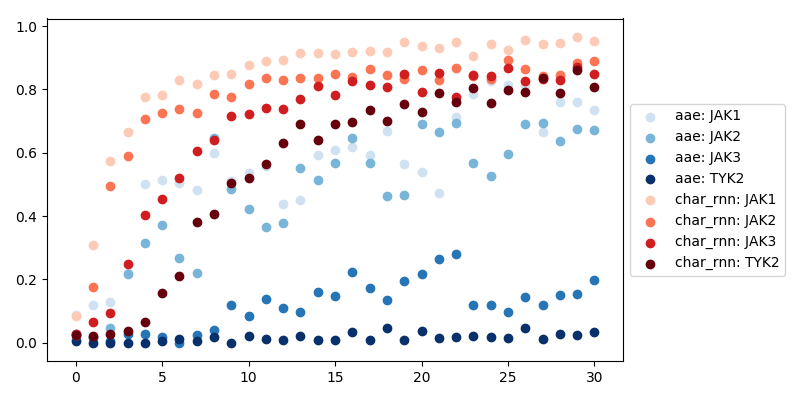

In [16]:
plt.close()
plt.figure(figsize=(8,4))
def sigmoid(x, x0, k):
  y = 1 / (1 + np.exp(-k*(x-x0)))
  return y
idx = d.index
colors = [plt.cm.Blues(np.linspace(0.2,1,len(idx))),plt.cm.Reds(np.linspace(0.2,1,len(idx)))]
for j,col in enumerate(d.columns):
  for i,target in enumerate(idx):
    x = np.array(range(len(d[col][target])))
    y = d[col][target]
    popt, pcov = scipy.optimize.curve_fit(sigmoid, x, y, maxfev=10000)
    
    plt.scatter(x, d[col][target], color=colors[j][i],label=str(col)+': '+str(target))
    #plt.plot(x, sigmoid(x, *popt), color=colors[j][i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
display(plt.show())

In [17]:
%sh ls -lht /dbfs/FileStore/ZINC/virtual_screening

total 0
-rw-r--r-- 1 root root 194K Jun 12 21:28 char_rnn-13t09-filt-train_vsTYK2-iter9x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 1.2M Jun 12 21:28 char_rnn-13t09-filt_gen10000_vsTYK2-iter9x10e50seedTest-10actives-preds-uniq.csv
-rw-r--r-- 1 root root 394K Jun 12 21:27 char_rnn-13t09-filt_gen10000_vsTYK2-iter9x10e50seedTest-10actives-uniq.smi
drwxr-xr-x 1 root root 0 Jun 12 21:25 models
-rw-r--r-- 1 root root 171K Jun 12 21:24 char_rnn-13t09-filt-train_vsTYK2-iter8x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 1.1M Jun 12 21:24 char_rnn-13t09-filt_gen10000_vsTYK2-iter8x10e50seedTest-10actives-preds-uniq.csv
-rw-r--r-- 1 root root 383K Jun 12 21:24 char_rnn-13t09-filt_gen10000_vsTYK2-iter8x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 148K Jun 12 21:21 char_rnn-13t09-filt-train_vsTYK2-iter7x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 1.1M Jun 12 21:21 char_rnn-13t09-filt_gen10000_vsTYK2-iter7x10e50seedTest-10actives-preds-uniq.csv
-rw-r--r-- 1 root root 368K Jun 12 21:21 char_rnn-13t09-filt_gen10000_vsTYK2-iter7x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 125K Jun 12 21:18 char_rnn-13t09-filt-train_vsTYK2-iter6x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 1.1M Jun 12 21:18 char_rnn-13t09-filt_gen10000_vsTYK2-iter6x10e50seedTest-10actives-preds-uniq.csv
-rw-r--r-- 1 root root 360K Jun 12 21:18 char_rnn-13t09-filt_gen10000_vsTYK2-iter6x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 106K Jun 12 21:16 char_rnn-13t09-filt-train_vsTYK2-iter5x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 1.1M Jun 12 21:16 char_rnn-13t09-filt_gen10000_vsTYK2-iter5x10e50seedTest-10actives-preds-uniq.csv
-rw-r--r-- 1 root root 347K Jun 12 21:15 char_rnn-13t09-filt_gen10000_vsTYK2-iter5x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 86K Jun 12 21:13 char_rnn-13t09-filt-train_vsTYK2-iter4x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 1.1M Jun 12 21:13 char_rnn-13t09-filt_gen10000_vsTYK2-iter4x10e50seedTest-10actives-preds-uniq.csv
-rw-r--r-- 1 root root 337K Jun 12 21:13 char_rnn-13t09-filt_gen10000_vsTYK2-iter4x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 66K Jun 12 21:10 char_rnn-13t09-filt-train_vsTYK2-iter3x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 1.1M Jun 12 21:10 char_rnn-13t09-filt_gen10000_vsTYK2-iter3x10e50seedTest-10actives-preds-uniq.csv
-rw-r--r-- 1 root root 330K Jun 12 21:10 char_rnn-13t09-filt_gen10000_vsTYK2-iter3x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 47K Jun 12 21:08 char_rnn-13t09-filt-train_vsTYK2-iter2x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 1.1M Jun 12 21:08 char_rnn-13t09-filt_gen10000_vsTYK2-iter2x10e50seedTest-10actives-preds-uniq.csv
-rw-r--r-- 1 root root 324K Jun 12 21:07 char_rnn-13t09-filt_gen10000_vsTYK2-iter2x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 30K Jun 12 21:05 char_rnn-13t09-filt-train_vsTYK2-iter1x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 1.1M Jun 12 21:05 char_rnn-13t09-filt_gen10000_vsTYK2-iter1x10e50seedTest-10actives-preds-uniq.csv
-rw-r--r-- 1 root root 332K Jun 12 21:05 char_rnn-13t09-filt_gen10000_vsTYK2-iter1x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 11K Jun 12 21:03 char_rnn-13t09-filt-train_vsTYK2-iter0x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 1.1M Jun 12 21:03 char_rnn-13t09-filt_gen10000_vsTYK2-iter0x10e50seedTest-10actives-preds-uniq.csv
-rw-r--r-- 1 root root 356K Jun 12 21:03 char_rnn-13t09-filt_gen10000_vsTYK2-iter0x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 210K Jun 12 21:01 char_rnn-13t09-filt-train_vsJAK3-iter9x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 1.2M Jun 12 21:01 char_rnn-13t09-filt_gen10000_vsJAK3-iter9x10e50seedTest-10actives-preds-uniq.csv
-rw-r--r-- 1 root root 383K Jun 12 21:00 char_rnn-13t09-filt_gen10000_vsJAK3-iter9x10e50seedTest-10actives-uniq.smi
-rw-r--r-- 1 root root 188K Jun 12 20:57 char_rnn-13t09-filt-train_vsJAK3-iter8x10e50seedTe

# Simulation runs

In [19]:
from rdkit.Chem.Fingerprints import FingerprintMols

#100actives - seed
def count_neighbors(gen_smiles, true_smiles,dist_thresh):
  true_mols = [Chem.MolFromSmiles(smi) for smi in true_smiles]
  gen_mols = [Chem.MolFromSmiles(smi) for smi in gen_smiles]
  #print(gen_mols)
  neighbor_counts = [sum(np.array(DataStructs.BulkTanimotoSimilarity(gen_mol,[FingerprintMols.FingerprintMol(x) for x in true_mols]))>dist_thresh) for gen_mol in gen_mols]
  return neighbor_counts


delete_list = ["<pad>"]
def fix_gen_output(infile, outfile):
  fin = open(infile)
  fout = open(outfile, "w+")
  for line in fin:
      for word in delete_list:
          line = line.replace(word, "")
      fout.write(line)
  fin.close()
  fout.close()

n_actives = 'class-vsjak2-neigh1x05-allseed-'
ITERATIONS = [10,10]
epochs = ['20','10']
n_samples = '10000'
targets = ['JAK1','JAK3','TYK2']
VS_Models = os.path.join(VIRTUAL_SCREENING,'models')
for k,model in enumerate(models):
  
  for j,target in enumerate(targets):
    train_load = os.path.join(VIRTUAL_SCREENING,target+'_actives.smi')
    model_state = os.path.join(ZINC_Models,model+'-13t09-filt.model')
    true_actives = list(set(pd.read_csv(os.path.join(VIRTUAL_SCREENING,target+'_actives.smi')).SMILES.tolist()))
    true_mols = [Chem.MolFromSmiles(smi) for smi in true_actives]
    true_fps = [FingerprintMols.FingerprintMol(x) for x in true_mols]
    for i in range(ITERATIONS[k]):
      # training
      model_load = os.path.join(VS_Models,model+'-13t09-filt_vs'+target+'-iter'+str(i)+'x'+str(ITERATIONS[k])+'e50seedTest-'+n_actives+'actives-train-uniq.model')
      config_load = os.path.join(VS_Models,model+'-13t09-filt_vs'+target+'-iter'+str(i)+'x'+str(ITERATIONS[k])+'e50seedTest-'+n_actives+'actives-train-uniq.config')
      vocab_load = os.path.join(VS_Models,model+'-13t09-filt_vs'+target+'-iter'+str(i)+'x'+str(ITERATIONS[k])+'e50seedTest-'+n_actives+'actives-train-uniq.vocab')
      MODELS = ModelsStorage()
      parser = moses_parser_train()
      config = parser.parse_args([model,
                                  '--seed', '13',
                                  '--train_load',train_load,
                                  '--model_save',model_load,
                                  '--config_save',config_load,
                                  '--train_epochs',epochs[k],
                                  '--vocab_load',os.path.join(ZINC_Models,model+'-13t09-filt.vocab'),
                                  '--vocab_save',vocab_load,
                                  '--log_file',os.path.join(VS_Models,model+'-13t09-filt_vs'+target+'-iter'+str(i)+'x'+str(ITERATIONS[k])+'e50seedTest-'+n_actives+'actives-train-uniq.log')])
      moses_train(model,config,model_state = torch.load(model_state))
      #generation
      gen_save = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt_gen'+n_samples+'_vs'+target+'-iter'+str(i)+'x'+str(ITERATIONS[k])+'e50seedTest-'+n_actives+'actives-train-uniq.smi')
      fixed = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt_gen'+n_samples+'_vs'+target+'-iter'+str(i)+'x'+str(ITERATIONS[k])+'e50seedTest-'+n_actives+'actives-train-uniq-fixed.smi')
      print(i)
      MODELS = ModelsStorage()
      gen_parser = moses_parser_generate()
      config = gen_parser.parse_args([model,'--model_load',model_load,
                                      '--config_load',config_load,
                                      '--vocab_load',vocab_load,
                                      '--n_samples',n_samples,
                                      '--gen_save',gen_save])

      moses_generate(model,config)
      fix_gen_output(gen_save, fixed)
      gen_save = fixed
      
      #prediction
      preds_path = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt_gen'+n_samples+'_vs'+target+'-iter'+str(i)+'x'+str(ITERATIONS[k])+'e50seedTest-'+n_actives+'actives-preds-train-uniq.csv')
      checkpoint_path = os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-bin76_ext','fold_0/model_0/model.pt')
      #checkpoint_dir = os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-2188-sparse-regression-scaffold')

      pred_parser = ArgumentParser()
      add_predict_args(pred_parser)
      args = pred_parser.parse_args(['--test_path',gen_save,
                                     '--checkpoint_path',checkpoint_path,
                                     #'--checkpoint_dir',checkpoint_dir,
                                     '--preds_path',preds_path,
                                     #'--features_path',features_path,
                                    ])
      
      modify_predict_args(args)
      print(args)
      make_predictions(args)
      
      #filtering
      preds = pd.read_csv(preds_path)
      #preds = preds[(preds[target]>7.6)]
      #preds = preds[preds['JAK2']<5]
      preds = preds[(preds[target]>0.5)&(preds['JAK2']<0.5)]
      print(preds.head())
      all_smiles = pd.read_csv(train_load)
      #
      preds['mols'] = [Chem.MolFromSmiles(smi) for smi in preds.smiles]
      preds.dropna(subset=['mols'],inplace=True)
      
      gen_mols = preds.mols.tolist()
      #neighbor_counts = count_neighbors(preds.smiles,true_actives,0.2)
      
      neighbor_counts = [sum(np.array(DataStructs.BulkTanimotoSimilarity(FingerprintMols.FingerprintMol(gen_mol),true_fps))>0.6) for gen_mol in gen_mols]
      preds = preds[np.array(neighbor_counts)>10]
      print(all_smiles.head())
      all_smiles = all_smiles.SMILES.append(preds.smiles)
      all_smiles.dropna(inplace=True)
      all_smiles.smiles = [Chem.MolToSmiles(Chem.MolFromSmiles(smi), canonical=True) for smi in all_smiles if Chem.MolFromSmiles(smi)]
      all_smiles.drop_duplicates(inplace=True)
      print('Molecules for next trainng round:',len(all_smiles))
      print(all_smiles.tail())
      train_load = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt-train'+'_vs'+target+'-iter'+str(i)+'x'+str(ITERATIONS[k])+'e50seedTest-'+n_actives+'actives-train-uniq.smi')
      all_smiles.to_csv(train_load,index=False, header=['SMILES'])
      model_state = model_load


Training (epoch #0): 0%| | 0/7 [00:00<?, ?it/s]Training (epoch #0): 0%| | 0/7 [00:00<?, ?it/s, autoencoder_loss=3.96, generator_loss=0.691, discriminator_loss=0.692]Training (epoch #0): 14%|█▍ | 1/7 [00:00<00:00, 9.54it/s, autoencoder_loss=3.96, generator_loss=0.691, discriminator_loss=0.692]Training (epoch #0): 14%|█▍ | 1/7 [00:00<00:00, 9.54it/s, autoencoder_loss=3.95, generator_loss=0.635, discriminator_loss=0.757]Training (epoch #0): 29%|██▊ | 2/7 [00:00<00:00, 9.29it/s, autoencoder_loss=3.95, generator_loss=0.635, discriminator_loss=0.757]Training (epoch #0): 29%|██▊ | 2/7 [00:00<00:00, 9.29it/s, autoencoder_loss=3.39, generator_loss=0.622, discriminator_loss=0.699]Training (epoch #0): 29%|██▊ | 2/7 [00:00<00:00, 9.29it/s, autoencoder_loss=2.87, generator_loss=0.608, discriminator_loss=0.734]Training (epoch #0): 57%|█████▋ | 4/7 [00:00<00:00, 9.55it/s, autoencoder_loss=2.87, generator_loss=0.608, discriminator_loss=0.734]Training (epoch #0): 57%|█████▋ | 4/7 [00:00<00:00, 9.55it/s, autoencoder_loss=2.52, generator_loss=0.602, discriminator_loss=0.7] Training (epoch #0): 57%|█████▋ | 4/7 [00:00<00:00, 9.55it/s, autoencoder_loss=2.26, generator_loss=0.595, discriminator_loss=0.724]Training (epoch #0): 86%|████████▌ | 6/7 [00:00<00:00, 9.68it/s, autoencoder_loss=2.26, generator_loss=0.595, discriminator_loss=0.724]Training (epoch #0): 86%|████████▌ | 6/7 [00:00<00:00, 9.68it/s, autoencoder_loss=2.06, generator_loss=0.592, discriminator_loss=0.702]Training (epoch #0): 100%|██████████| 7/7 [00:00<00:00, 9.95it/s, autoencoder_loss=2.06, generator_loss=0.592, discriminator_loss=0.702]
Training (epoch #1): 0%| | 0/7 [00:00<?, ?it/s]Training (epoch #1): 0%| | 0/7 [00:00<?, ?it/s, autoencoder_loss=0.782, generator_loss=0.564, discriminator_loss=0.559]Training (epoch #1): 14%|█▍ | 1/7 [00:00<00:00, 9.70it/s, autoencoder_loss=0.782, generator_loss=0.564, discriminator_loss=0.559]Training (epoch #1): 14%|█▍ | 1/7 [00:00<00:00, 9.70it/s, autoencoder_loss=0.775, generator_loss=0.552, discriminator_loss=0.717]Training (epoch #1): 29%|██▊ | 2/7 [00:00<00:00, 9.46it/s, autoencoder_loss=0.775, generator_loss=0.552, discriminator_loss=0.717]Training (epoch #1): 29%|██▊ | 2/7 [00:00<00:00, 9.46it/s, autoencoder_loss=0.748, generator_loss=0.548, discriminator_loss=0.658]Training (epoch #1): 29%|██▊ | 2/7 [00:00<00:00, 9.46it/s, autoencoder_loss=0.712, generator_loss=0.543, discriminator_loss=0.717]Training (epoch #1): 57%|█████▋ | 4/7 [00:00<00:00, 9.62it/s, autoencoder_loss=0.712, generator_loss=0.543, discriminator_loss=0.717]Training (epoch #1): 57%|█████▋ | 4/7 [00:00<00:00, 9.62it/s, autoencoder_loss=0.693, generator_loss=0.541, discriminator_loss=0.681]Training (epoch #1): 57%|█████▋ | 4/7 [00:00<00:00, 9.62it/s, autoencoder_loss=0.68, generator_loss=0.539, discriminator_loss=0.716] Training (epoch #1): 86%|████████▌ | 6/7 [00:00<00:00, 9.80it/s, autoencoder_loss=0.68, generator_loss=0.539, discriminator_loss=0.716]Training (epoch #1): 86%|████████▌ | 6/7 [00:00<00:00, 9.80it/s, autoencoder_loss=0.674, generator_loss=0.539, discriminator_loss=0.692]Training (epoch #1): 100%|██████████| 7/7 [00:00<00:00, 10.06it/s, autoencoder_loss=0.674, generator_loss=0.539, discriminator_loss=0.692]
Training (epoch #2): 0%| | 0/7 [00:00<?, ?it/s]Training (epoch #2): 0%| | 0/7 [00:00<?, ?it/s, autoencoder_loss=0.545, generator_loss=0.539, discriminator_loss=0.548]Training (epoch #2): 0%| | 0/7 [00:00<?, ?it/s, autoencoder_loss=0.506, generator_loss=0.533, discriminator_loss=0.72] Training (epoch #2): 29%|██▊ | 2/7 [00:00<00:00, 10.28it/s, autoencoder_loss=0.506, generator_loss=0.533, discriminator_loss=0.72]Training (epoch #2): 29%|██▊ | 2/7 [00:00<00:00, 10.28it/s, autoencoder_loss=0.477, generator_loss=0.533, discriminator_loss=0.66]Training (epoch #2): 29%|██▊ | 2/7 [00:00<00:00, 10.28it/s, autoencoder_loss=0.449, generator_loss=0.531, discriminator_loss=0.719]Training (epoch #2): 57%|█████▋ | 4/7 [00:00<00:00, 10.14it

In [20]:
from rdkit.Chem.Fingerprints import FingerprintMols
# Re-doing some predictions
n_actives = 'prob07-neighbors-allseed-'
ITERATIONS = [10,10]
epochs = ['20','10']
n_samples = '10000'
targets = ['JAK1','JAK2','JAK3','TYK2']
VS_Models = os.path.join(VIRTUAL_SCREENING,'models')
for k,model in enumerate(models):
  
  for j,target in enumerate(targets):
    for i in [9]:
      gen_save = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt-train'+'_vs'+target+'-iter'+str(i)+'x'+str(ITERATIONS[k])+'e50seedTest-'+n_actives+'actives-train-uniq.smi')
      #prediction
      preds_path = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt_gen'+n_samples+'_vs'+target+'-iter'+str(i)+'x'+str(ITERATIONS[k])+'e50seedTest-'+n_actives+'actives-preds-regression-train-uniq.csv')
      checkpoint_dir = os.path.join(CHEMPROP_DIR,'JAK','hyperopt_4x-2188-sparse-regression-scaffold')


      pred_parser = ArgumentParser()
      add_predict_args(pred_parser)
      args = pred_parser.parse_args(['--test_path',gen_save,
                                     #'--checkpoint_path',checkpoint_path,
                                     '--checkpoint_dir',checkpoint_dir,
                                     '--preds_path',preds_path,
                                     #'--features_path',features_path,
                                    ])
      modify_predict_args(args)
      make_predictions(args)

Loading training args
Loading data
 0%| | 0/3237 [00:00<?, ?it/s] 9%|▊ | 281/3237 [00:00<00:01, 2805.73it/s] 18%|█▊ | 571/3237 [00:00<00:00, 2830.86it/s] 27%|██▋ | 872/3237 [00:00<00:00, 2880.65it/s] 44%|████▍ | 1430/3237 [00:00<00:00, 3369.47it/s] 64%|██████▎ | 2062/3237 [00:00<00:00, 3917.98it/s] 84%|████████▎ | 2709/3237 [00:00<00:00, 4442.98it/s]100%|██████████| 3237/3237 [00:00<00:00, 4699.97it/s]
Validating SMILES
Test size = 3,237
Predicting with an ensemble of 5 models
 0%| | 0/5 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda

 0%| | 0/65 [00:00<?, ?it/s]
 6%|▌ | 4/65 [00:00<00:01, 31.37it/s]
 12%|█▏ | 8/65 [00:00<00:01, 32.27it/s]
 18%|█▊ | 12/65 [00:00<00:01, 32.76it/s]
 25%|██▍ | 16/65 [00:00<00:01, 33.50it/s]
 32%|███▏ | 21/65 [00:00<00:01, 36.89it/s]
 42%|████▏ | 27/65 [00:00<00:00, 40.88it/s]
 51%|█████ | 33/65 [00:00<00:00, 43.63it/s]
 60%|██████ | 39/65 [00:00<00:00, 46.58it/s]
 69%|██████▉ | 45/65 [00:01<00:00, 48.22it/s]
 78%|███████▊ | 51/65 [00:01<00:00, 49.41it/s]
 88%|████████▊ | 57/65 [00:01<00:00, 51.05it/s]
 97%|█████████▋| 63/65 [00:01<00:00, 52.07it/s]100%|██████████| 65/65 [00:01<00:00, 46.66it/s]
 20%|██ | 1/5 [00:03<00:15, 3.79s/it]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda

 0%| | 0/65 [00:00<?, ?it/s]
 6%|▌ | 4/65 [00:00<00:01, 35.80it/s]
 12%|█▏ | 8/65 [00:00<00:01, 35.83it/s]
 18%|█▊ | 12/65 [00:00<00:01, 36.54it/s]
 25%|██▍ | 16/65 [00:00<00:01, 36.82it/s]
 34%|███▍ | 22/65 [00:00<00:01, 38.48it/s]
 43%|████▎ | 28/65 [00:00<00:00, 42.24it/s]
 52%|█████▏ | 34/65 [00:00<00:00, 45.61it/s]
 62%|██████▏ | 40/65 [00:00<00:00, 48.39it/s]
 71%|███████ | 46/65 [00:01<00:00, 50.65it/s]
 80%|████████ | 52/65 [00:01<00:00, 51.57it/s]
 89%|████████▉ | 58/65 [00:01<00:00, 53.19it/s]
 98%|█████████▊| 64/65 [00:01<00:00, 54.30it/s]100%|██████████| 65/65 [00:01<00:00, 48.59it/s]
 40%|████ | 2/5 [00:08<00:12, 4.04s/it]Loading pretrained parameter "encoder.encoder.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.W_i.weight".
Loading pretrained parameter "encoder.encoder.W_h.weight".
Loading pretrained parameter "encoder.encoder.W_o.weight".
Loading pretrained parameter "encoder.encoder.W_o.bias".
Loading pretrained parameter "ffn.1.weight".
Loading pretrained parameter "ffn.1.bias".
Loading pretrained parameter "ffn.4.weight".
Loading pretrained parameter "ffn.4.bias".
Moving model to cuda

 0%| | 0/65 [00:00<?, ?it/s]
 6%|▌ | 4/65 [00:00<00:01, 36.62it/s]
 12%|█▏ | 8/65 [00:00<00:01, 37.39it/s]
 18%|█▊ | 12/65 [00:00<00:01, 37.22it/s]
 25%|██▍ | 16/65 [00:00<00:01, 35.20it/s]
 32%|███▏ | 21/65 [00:00<00:01, 38.53it/s]
 42%|████▏ | 27/65 [00:00<00:00, 42.07it/s]
 51%|█████ | 33/65 [00:00<00:00, 45.47it/s]
 60%|██████ | 39/65 [00:00<00:00, 47.16it/s]
 69%|██████▉ | 45/65 [00:00<00:00, 49.78it/s]
 78%|███████▊ | 51/65 [00:01<00:00, 51.74it/s]
 88%|████████▊ | 57/65 [00:01<00:00, 53.21it/s]
 97%|█████████▋| 63/65 [00:01<00:00, 51.67it/s]100%|██████████| 65/65 [00:01<00:00, 47.91it/s]
 60%|██████ | 3/5 [00:12<00:08, 4.05s/it]Loading pretrai

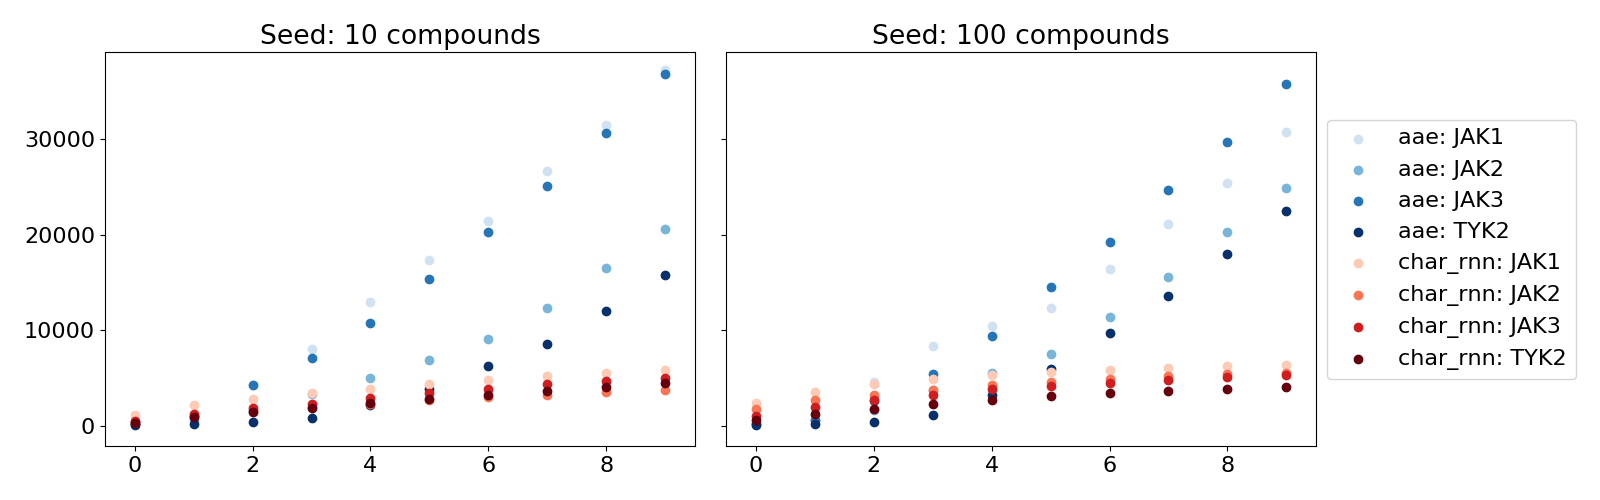

In [21]:
X_train = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all-1825.csv')).smiles.tolist()
d = {}
#10actives - seed
ITERATIONS = [10,10]
n_samples = '10000'
targets = ['JAK1','JAK2','JAK3','TYK2']
VS_Models = os.path.join(VIRTUAL_SCREENING,'models')

for k,model in enumerate(models):
  mod_d = {}
  for j,target in enumerate(targets):
    iters = []
    #train_load = os.path.join(VIRTUAL_SCREENING,target+'_10actives.smi')
    #model_state = os.path.join(ZINC_Models,model+'-13t09-filt.model')
    for i in range(ITERATIONS[k]):
      seeds = []
      for s, seed in enumerate(['10','prob08-trainseed-100']):
        inputs = [os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt-train'+'_vs'+target+'-iter'+str(i)+'x'+str(ITERATIONS[k])+'e50seedTest-'+seed+'actives-uniq.smi'),
                  os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt-train'+'_vs'+target+'-iter'+str(i)+'x'+str(ITERATIONS[k])+'e50seedTest-'+seed+'actives-train-uniq.smi')]
        preds_path = inputs[s]
        mols = [Chem.MolFromSmiles(smi) for smi in pd.read_csv(preds_path,squeeze=True).tolist() if Chem.MolFromSmiles(smi)]
        smiles = [Chem.MolToSmiles(mol,canonical=True) for mol in mols]
        preds = set(smiles)#.filter([target])#.dropna()
        #valid_preds = len(preds)
        #preds = preds[preds[target]>0.5]
        #print(preds.head())
        #actives = np.array(preds.dropna()) > 0.5
        #ratio_full = sum(actives)/len(preds)
        #ratio_valid = sum(actives)/valid_preds
        seeds.append(len(preds))
      iters.append(seeds)
    mod_d[target] = iters
  d[model] = mod_d
d = pd.DataFrame(d)
print(d.head())
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
plt.close()
f, axes = plt.subplots(figsize=(16,5),ncols = 2,sharey=True)

idx = d.index
colors = [plt.cm.Blues(np.linspace(0.2,1,len(idx))),plt.cm.Reds(np.linspace(0.2,1,len(idx)))]
for k, ax in enumerate(axes):
  for j,col in enumerate(d.columns):
    for i,target in enumerate(idx):
      x = np.array(range(len(d[col][target])))
      

      ax.scatter(x, np.array(d[col][target])[:,k], color=colors[j][i],label=str(col)+': '+str(target))
      ax.set_title('Seed: '+['10','100'][k]+' compounds')
      #plt.plot(x, sigmoid(x, *popt), color=colors[j][i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
display(plt.show())

# MOSES evaluations

In [23]:
%sh
/databricks/python/bin/pip install molsets
find /databricks/python/lib/python3.6/site-packages/moses/ -type f -print0 | xargs -0 sed -i 's/from\ rdkit.six.moves\ import\ cPickle/import\ _pickle\ as\ cPickle/g'

Collecting molsets
 Downloading https://files.pythonhosted.org/packages/d2/69/07e97e29998f9a0ef43ae3f9767faaaeec0c1e3b92796a57185574d4ef03/molsets-0.1.3-py3-none-any.whl (6.0MB)
Requirement already satisfied: matplotlib>=3.0.0 in /databricks/python3/lib/python3.6/site-packages (from molsets) (3.0.3)
Requirement already satisfied: seaborn in /databricks/python3/lib/python3.6/site-packages (from molsets) (0.9.0)
Requirement already satisfied: pandas>=0.23 in /databricks/python3/lib/python3.6/site-packages (from molsets) (0.23.0)
Requirement already satisfied: scipy>=1.1.0 in /databricks/python3/lib/python3.6/site-packages (from molsets) (1.1.0)
Collecting fcd-torch>=1.0.5 (from molsets)
 Downloading https://files.pythonhosted.org/packages/48/45/476df503cd87d28486af12c37b2e71fc5d0b2730f9bd0539cf19782678b8/fcd_torch-1.0.7-py3-none-any.whl (5.2MB)
Collecting numpy>=1.15 (from molsets)
 Downloading https://files.pythonhosted.org/packages/87/2d/e4656149cbadd3a8a0369fcd1a9c7d61cc7b87b3903b85389c70c989a696/numpy-1.16.4-cp36-cp36m-manylinux1_x86_64.whl (17.3MB)
Collecting torch>=1.0.1 (from molsets)
 Downloading https://files.pythonhosted.org/packages/69/60/f685fb2cfb3088736bafbc9bdbb455327bdc8906b606da9c9a81bae1c81e/torch-1.1.0-cp36-cp36m-manylinux1_x86_64.whl (676.9MB)
Requirement already satisfied: tqdm>=4.26.0 in /databricks/python3/lib/python3.6/site-packages (from molsets) (4.32.2)
Requirement already satisfied: python-dateutil>=2.1 in /databricks/python3/lib/python3.6/site-packages (from matplotlib>=3.0.0->molsets) (2.7.3)
Requirement already satisfied: kiwisolver>=1.0.1 in /databricks/python3/lib/python3.6/site-packages (from matplotlib>=3.0.0->molsets) (1.1.0)
Requirement already satisfied: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /databricks/python3/lib/python3.6/site-packages (from matplotlib>=3.0.0->molsets) (2.2.0)
Requirement already satisfied: cycler>=0.10 in /databricks/python3/lib/python3.6/site-packages (from matplotlib>=3.0.0->molsets) (0.10.0)
Requirement already satisfied: pytz>=2011k in /databricks/python3/lib/python3.6/site-packages (from pandas>=0.23->molsets) (2018.4)
Requirement already satisfied: six>=1.5 in /databricks/python3/lib/python3.6/site-packages (from python-dateutil>=2.1->matplotlib>=3.0.0->molsets) (1.11.0)
Requirement already satisfied: setuptools in /databricks/python3/lib/python3.6/site-packages (from kiwisolver>=1.0.1->matplotlib>=3.0.0->molsets) (39.1.0)
Installing collected packages: numpy, torch, fcd-torch, molsets
 Found existing installation: numpy 1.14.3
 Uninstalling numpy-1.14.3:
 Successfully uninstalled numpy-1.14.3
 Found existing installation: torch 0.4.1
 Uninstalling torch-0.4.1:
 Successfully uninstalled torch-0.4.1
Successfully installed fcd-torch-1.0.7 molsets-0.1.3 numpy-1.16.4 torch-1.1.0
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [24]:
import moses
from moses.script_utils import add_train_args, read_smiles_csv, set_seed, add_sample_args
from moses.models_storage import ModelsStorage
from moses.metrics.metrics import get_all_metrics
from tqdm import tqdm
from moses.metrics import FrechetMetric, NP, weight, logP, SA, QED
from moses.metrics.utils import get_mol, mapper
from moses.utils import disable_rdkit_log

In [25]:
def evaluate(config, print_metrics=True):
    test = read_smiles_csv(config.test_path)
    test_scaffolds = None
    ptest = None
    ptest_scaffolds = None
    if config.test_scaffolds_path is not None:
        test_scaffolds = read_smiles_csv(config.test_scaffolds_path)
    gen = read_smiles_csv(config.gen_path)
    metrics = get_all_metrics(test, gen, k=config.ks, n_jobs=config.n_jobs,
                              device=config.device,
                              test_scaffolds=test_scaffolds,
                              ptest=ptest, ptest_scaffolds=ptest_scaffolds)

    if print_metrics:
        for name, value in metrics.items():
            print('{},{}'.format(name, value))
    else:
        return metrics


def parser_eval():
    parser = argparse.ArgumentParser()
    parser.add_argument('--test_path',
                        type=str, required=True,
                        help='Path to test molecules csv')
    parser.add_argument('--test_scaffolds_path',
                        type=str, required=False,
                        help='Path to scaffold test molecules csv')
    parser.add_argument('--gen_path',
                        type=str, required=True,
                        help='Path to generated molecules csv')
    parser.add_argument('--ks',
                        nargs='+', default=[1000, 10000],
                        help='Prefixes to calc uniqueness at')
    parser.add_argument('--n_jobs',
                        type=int, default=6,
                        help='Number of processes to run metrics')
    parser.add_argument('--device',
                        type=str, default='cpu',
                        help='GPU device id (`cpu` or `cuda:n`)')
    return parser

In [26]:
parser = parser_eval()
config = parser.parse_known_args(['-h'])[0]
evaluate(config)


An exception has occurred, use %tb to see the full traceback.

 SystemExit : 0

In [27]:
from moses.metrics.metrics import compute_intermediate_statistics, SNNMetric, internal_diversity, fraction_valid, remove_invalid
from moses.utils import mapper
from moses.metrics.utils import get_mol
from multiprocessing import Pool
metrics = []
#n_actives = 'prob08-trainseed-100'
n_actives = 'class-vsjak2-neigh1x05-allseed-'
ITERATIONS = [10,10]
n_samples = '10000'
targets = ['JAK1','JAK3','TYK2']
VS_Models = os.path.join(VIRTUAL_SCREENING,'models')
for k,model in enumerate(models):
  print(model)
  mod_d = {}
  for j,target in enumerate(targets):
    print(target)
    #iters = []
    #train_load = os.path.join(VIRTUAL_SCREENING,target+'_10actives.smi')
    #model_state = os.path.join(ZINC_Models,model+'-13t09-filt.model')
    size = set()
    for i in range(ITERATIONS[k]):
      #metric_dict = {}
      preds_path = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt-train'+'_vs'+target+'-iter'+str(i)+'x'+str(10)+'e50seedTest-'+n_actives+'actives-train-uniq.smi')
      preds = pd.read_csv(preds_path).filter(['SMILES'])

      device='cpu'
      batch_size=512
      n_jobs=1
      pool=Pool(n_jobs)
      test = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all-1825.csv')).smiles.tolist()
      gen = preds.smiles.tolist()
      metric_dict = {}
      metric_dict['valid'] = fraction_valid(gen, n_jobs=pool)
      gen = remove_invalid(gen, canonize=True)
      mols = mapper(pool)(get_mol, gen)
      ptest = compute_intermediate_statistics(test, n_jobs=n_jobs,
                                                device=device,
                                                batch_size=batch_size,
                                                pool=pool)
      kwargs = {'n_jobs': n_jobs, 'device': device, 'batch_size': batch_size}
      
      metric_dict['SNN/Test'] = SNNMetric(**kwargs)(gen=mols, pref=ptest['SNN'])
      metric_dict['IntDiv'] = internal_diversity(mols, pool, device=device)
      valid_preds = preds.dropna(subset=[target]).drop_duplicates(subset=['smiles'])
      metric_dict['Frac_actives'] = len(valid_preds[valid_preds[target]>0.5])/len(valid_preds)
      preds = set(pd.read_csv(preds_path).filter(['smiles',target]).drop_duplicates().dropna().smiles.tolist())
      actives = set(pd.read_csv(os.path.join(VIRTUAL_SCREENING,target+'_actives.smi')).SMILES.tolist()) #os.path.join(VIRTUAL_SCREENING,target+'_actives.smi')
      metric_dict['Real_actives'] = len(preds&actives)/len(actives)
      metric_dict['Model'] = model+': '+target
      mols = [Chem.MolFromSmiles(smi) for smi in preds.SMILES.tolist() if Chem.MolFromSmiles(smi)]
      smiles = [Chem.MolToSmiles(mol,canonical=True) for mol in mols]
      
      
      metric_dict['Iteration'] = i
      metric_dict['Size'] = len(preds)
      print(len(preds))
      metrics.append(metric_dict)

import pickle
pool.terminate()
pickle.dump(metrics,open(os.path.join(VIRTUAL_SCREENING,'metrics-class-vsjak2-neigh1x05-allseed.p'),'wb'))
metric_df =  pd.DataFrame(columns = metrics[0].keys()).append([pd.DataFrame.from_dict({k: [v] for k, v in met.items()}) for met in metrics])

metric_df.to_csv(os.path.join(VIRTUAL_SCREENING,'metrics-class-vsjak2-neigh1x05-allseed.csv'),index=False)

aae
JAK1
1290
2612
4842
7375
10472
13746
17880
22198
26425
31071
JAK3
296
324
337
354
386
426
518
642
818
1443
TYK2
113
114
116
119
125
151
298
429
928
2779
char_rnn
JAK1
1423
1976
2487
2994
3687
4250
4892
5502
6120
6717
JAK3
331
387
442
517
664
929
1334
2014
2972
4118
TYK2
115
119
124
126
131
143
177
205
265
381

In [28]:
metric_df =  pd.DataFrame(columns = metrics[0].keys()).append([pd.DataFrame.from_dict({k: [v] for k, v in met.items()}) for met in metrics])
#metric_df = metric_df.filter(['valid','unique@1000','FCD/Test','SNN/Test','Frag/Test','Scaf/Test','Model','Iteration','Frac_actives'])#,'IntDiv','IntDiv2'
metric_df = metric_df.merge(real_actives,on=['Model','Iteration'])
display(metric_df)# SNN, IntDiv, 

valid,unique@1000,FCD/Test,SNN/Test,Frag/Test,Scaf/Test,IntDiv,IntDiv2,Filters,logP,SA,QED,NP,weight,Model,Iteration,Frac_actives,Real_actives
0.30410000000000004,1.0,29.177678160306304,0.27547216476166336,0.6990425336793745,0.16025451936913193,0.8782517016214847,0.8665724401649314,0.5797435054258467,0.28280285902521296,0.3618070109917867,4.686458830350376E-5,0.20292668809914105,15764.33457012774,aae: JAK1,0,0.12072368421052632,0.0034285714285714284
0.3668,1.0,32.64036931269325,0.21773828888431826,0.3483725914409066,0.018661670304250144,0.8852996722921018,0.874194010395084,0.18184296619411122,6.173201009351289,1.6812402852466597,0.022899100237841606,0.4775583915232313,13685.146533484532,aae: JAK1,1,0.1317299808690899,0.0
0.8477,0.992,26.891457723278027,0.31424947979228174,0.6706400691310569,0.19497926216224282,0.8683690457494151,0.8474454586713045,0.5074908576147222,0.7213935153087201,0.30191023055343136,0.001610785277885371,0.1546264020685118,12187.388339020286,aae: JAK1,2,0.5148281424494354,0.009142857142857144
0.8035,0.997,32.293754904100105,0.2638092987679812,0.6480271137826246,0.13176139717207835,0.8847449172192385,0.8702297225436282,0.4949595519601742,0.5969724169545896,0.31071362075058495,0.002488894643393913,0.37695685465532836,16229.354811780791,aae: JAK1,3,0.48204350025290843,0.0
0.777,1.0,26.194720361985496,0.2879808978665443,0.6681528527851264,0.12260519801273151,0.8716499734121965,0.8564836064446956,0.38056628056628056,1.3549136527723684,0.2456037633040552,0.008889260626837439,0.2540525191063995,9643.557195375837,aae: JAK1,4,0.49328165374677,0.0034285714285714284
0.7964,1.0,30.406573918982563,0.24560703977003193,0.48544867268693925,0.09010882559851818,0.8767262000848233,0.8662698345730104,0.3468106479156203,2.996327396914203,0.40442922118484304,0.03047015092208652,0.4134855059239498,6212.222019527668,aae: JAK1,5,0.5699384190021365,0.0
0.7698,1.0,34.56782693964937,0.21691948338321013,0.43450626939846493,0.015776946170258488,0.868434893676999,0.8595015742864842,0.1856326318524292,1.9495846556019112,0.6642375997516944,0.041996722124648264,0.4035273988083237,5406.676461217938,aae: JAK1,6,0.6652377240841777,0.001142857142857143
0.8588,1.0,31.199691400437622,0.2226842359839676,0.46609391074970064,0.010644873979310021,0.869627409847695,0.8616810310330415,0.19131346064275734,1.7746062049466218,1.5277095271284926,0.04061530029262543,0.7441559566258262,4628.405161185661,aae: JAK1,7,0.7597485740891631,0.0
0.8411,1.0,27.75862899253036,0.2450786194468548,0.484636186210447,0.05914368743494036,0.8730399701766005,0.8639983107410012,0.21388657710141482,2.933032230266681,0.9342752442327686,0.06007788528929227,0.3663817273708594,5090.353382747353,aae: JAK1,8,0.7017585551330798,0.0
0.9062,1.0,29.07323433346007,0.23766742362467114,0.4940260282981025,0.029958617301521384,0.8691548564103534,0.8608244078198395,0.1857205914809093,2.1375065166506877,1.1185639093558621,0.04872287836932646,0.435997252904141,4364.183186486212,aae: JAK1,9,0.8059504132231405,0.002285714285714286


In [29]:
metrics = pickle.load(open(os.path.join(VIRTUAL_SCREENING,'metrics-100actives.p'),'rb'))
metric_df =  pd.DataFrame(columns = metrics[0].keys()).append([pd.DataFrame.from_dict({k: [v] for k, v in met.items()}) for met in metrics])
metric_df = metric_df.merge(real_actives,on=['Model','Iteration'])

metric_df.to_csv(os.path.join(VIRTUAL_SCREENING,'metric_df-100actives.csv'),index=False)
display(metric_df)

valid,unique@1000,FCD/Test,SNN/Test,Frag/Test,Scaf/Test,IntDiv,IntDiv2,Filters,logP,SA,QED,NP,weight,Model,Iteration,Frac_actives,Real_actives
0.35429999999999995,1.0,33.515425238762546,0.23835806652899352,0.5470639676065269,0.06589355737163627,0.8902504309915522,0.8807485298088286,0.5893310753598645,0.4030606854482426,0.47787191176770083,7.644890287625272E-5,0.3404411314290937,20432.35280742945,aae: JAK1,0,0.11086036671368124,0.0
0.3849,0.994,24.909736878492552,0.3236428482303622,0.844695274248866,0.13197002821603898,0.858348723063001,0.8407201189595954,0.6435437776045726,0.6142313639845232,0.3532631019110637,0.0037741773486028446,0.27565756496429245,8663.341834903531,aae: JAK1,1,0.34352755075138414,0.002285714285714286
0.786,0.988,25.59006824186793,0.3277835317998745,0.7701313672708489,0.23247102577406298,0.8575736711975044,0.8349333396166885,0.6623409669211195,0.32437878028854383,0.25882396331996727,1.1019332325108017E-4,0.93345763423703,20598.013025077053,aae: JAK1,2,0.4597894736842105,0.012571428571428572
0.6377999999999999,1.0,32.025664639435504,0.24997746335344279,0.6335037112294809,0.07832591412945,0.8815967220745143,0.8711007232143939,0.4147068046409533,1.0105064587973223,0.48599509979186895,0.021330396550519028,0.8644023049678684,7312.795518970324,aae: JAK1,3,0.5043914680050188,0.001142857142857143
0.7719,0.999,32.49170782596934,0.24267179544226988,0.500853053078252,0.04983756786221094,0.8869958257857296,0.8742278891192632,0.5582329317269076,1.610979113130366,0.327157272689103,0.006596751831111712,0.8364529965193799,16664.480051671366,aae: JAK1,4,0.46563394949231973,0.001142857142857143
0.7564,1.0,35.04348928266192,0.22359006938296516,0.4807404129041273,0.03543417370755797,0.892584099674391,0.8821137333372677,0.4473823373876256,1.963594054272983,0.35197816079674604,0.01615200028236259,1.3281937582352694,17134.90642890453,aae: JAK1,5,0.4548344370860927,0.0
0.6064,1.0,31.64337797880025,0.2522233479562901,0.6528533634176772,0.07204457101056594,0.8828223356856184,0.8719100791215991,0.37104221635883905,4.019390825342875,0.5067106107220651,0.05809968017829374,0.6419962418965198,13720.43098197312,aae: JAK1,6,0.6120803159973667,0.0
0.732,1.0,29.136504487729425,0.26110510058049624,0.6072996369601676,0.08412449041729542,0.8732077078291165,0.8626635047169697,0.3790983606557377,9.403517105834034,0.7413854784284153,0.06432720651037213,0.951140061160671,14601.307670529299,aae: JAK1,7,0.6544959128065395,0.001142857142857143
0.8164,1.0,30.452165187343557,0.24603253715506873,0.5284468181355342,0.02893212199595141,0.881689950628691,0.8721157391214389,0.44145026947574717,3.806103017385964,0.3504772261128304,0.03439519389570646,0.8424900176053791,9235.8202607124,aae: JAK1,8,0.6052567237163814,0.0
0.7615000000000001,1.0,32.396637235532886,0.23277128836725858,0.537568276636401,0.03622605974290982,0.8857054799202912,0.8768757580140409,0.35022980958634276,3.5043341067600107,0.5250046642363911,0.04751283322646655,0.8697822587877764,8724.555528230092,aae: JAK1,9,0.6270609788013609,0.0


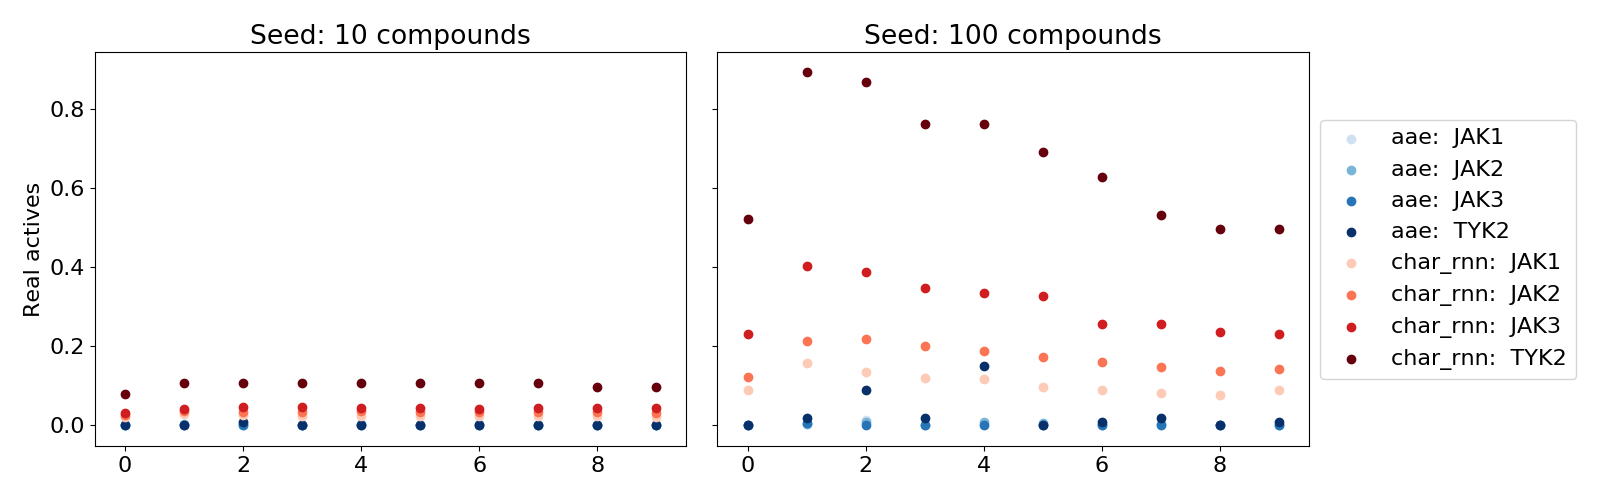

In [30]:
seed10 = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'metric_df-10actives.csv'))
seed10['target'] = [it.split(':')[1] for it in seed10.Model.tolist()]
seed10['Model'] = [it.split(':')[0] for it in seed10.Model.tolist()]
d100= metric_df.groupby(['target', 'Model'])['Real_actives'].apply(list).unstack(level='Model')
d10 = seed10.groupby(['target', 'Model'])['Real_actives'].apply(list).unstack(level='Model')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
plt.close()
f, axes = plt.subplots(figsize=(16,5),ncols = 2,sharey=True)

idx = d.index
colors = [plt.cm.Blues(np.linspace(0.2,1,len(idx))),plt.cm.Reds(np.linspace(0.2,1,len(idx)))]
for k, ax in enumerate(axes):
  d = [d10,d100][k]
  if k ==0:
    ax.set_ylabel('Real actives')
  for j,col in enumerate(d.columns):
    for i,target in enumerate(idx):
      x = np.array(range(len(d[col][target])))
      

      ax.scatter(x, np.array(d[col][target]), color=colors[j][i],label=str(col)+': '+str(target))
      ax.set_title('Seed: '+['10','100'][k]+' compounds')
      
      #plt.plot(x, sigmoid(x, *popt), color=colors[j][i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
display(plt.show())

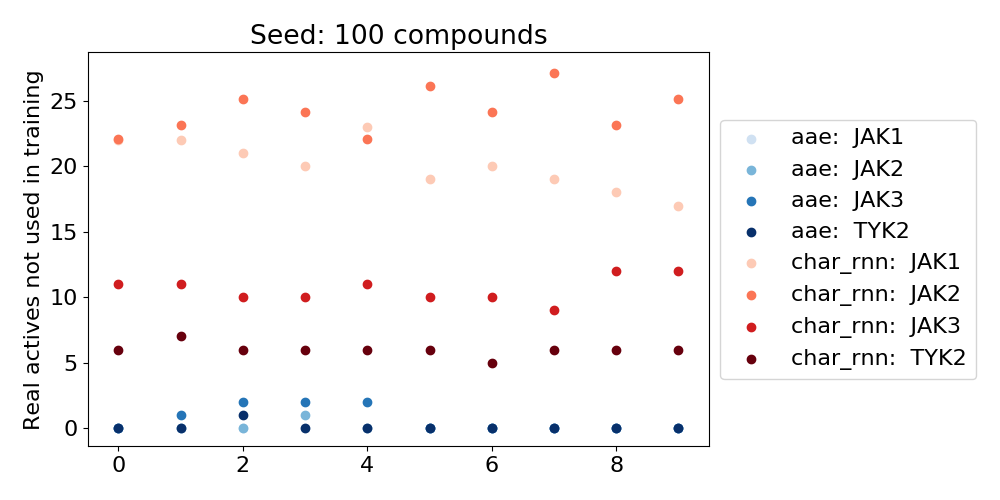

In [31]:
import matplotlib
metric_df = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'metric_df-100actives-train.csv'))
metric_df['target'] = [it.split(':')[1] for it in metric_df.Model.tolist()]
metric_df['Model'] = [it.split(':')[0] for it in metric_df.Model.tolist()]
d= metric_df.groupby(['target', 'Model'])['Real_actives'].apply(list).unstack(level='Model')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
plt.close()
f, ax = plt.subplots(figsize=(10,5),sharey=True)

idx = d.index
colors = [plt.cm.Blues(np.linspace(0.2,1,len(idx))),plt.cm.Reds(np.linspace(0.2,1,len(idx)))]


ax.set_ylabel('Real actives not used in training')
n_actives = [204,207,63,19]
for j,col in enumerate(d.columns):
  for i,target in enumerate(idx):
    x = np.array(range(len(d[col][target])))
    ax.scatter(x, np.array(d[col][target])*n_actives[i], color=colors[j][i],label=str(col)+': '+str(target))
    ax.set_title('Seed: 100 compounds')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax.set_ylim(-0.1,1)
plt.tight_layout()
display(plt.show())

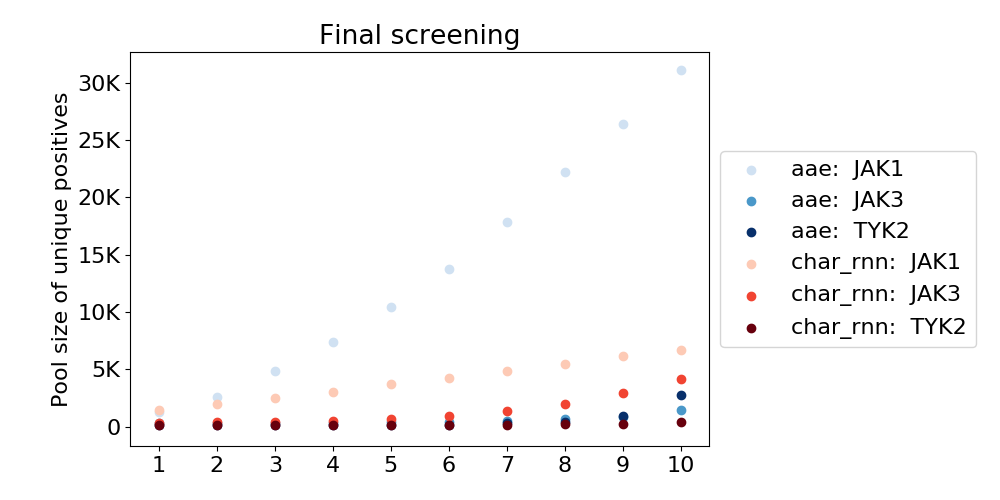

In [32]:
import matplotlib
#metric_df = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'metrics-class-vsjak2-neigh1x05-allseed.csv'))
#metric_df['target'] = [it.split(':')[1] for it in metric_df.Model.tolist()]
#metric_df['Model'] = [it.split(':')[0] for it in metric_df.Model.tolist()]
d= metric_df.groupby(['target', 'Model'])['Size'].apply(list).unstack(level='Model')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
plt.close()
f, ax = plt.subplots(figsize=(10,5),sharey=True)

idx = d.index
colors = [plt.cm.Blues(np.linspace(0.2,1,len(idx))),plt.cm.Reds(np.linspace(0.2,1,len(idx)))]


ax.set_ylabel('Pool size of unique positives')
for j,col in enumerate(d.columns):
  for i,target in enumerate(idx):
    x = np.array(range(len(d[col][target])))
    ax.scatter(x+1, np.array(d[col][target]), color=colors[j][i],label=str(col)+': '+str(target))#n_actives[i]
    ax.set_title('Final screening')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax.set_ylim(-0.1,1)
plt.tight_layout()
plt.xticks(np.arange(1, 11, 1.0))
#plt.yticks(['5K','10K','15K','20K','25K','30K'])
ax.set_yticklabels(['','0','5K','10K','15K','20K','25K','30K'])
display(plt.show())

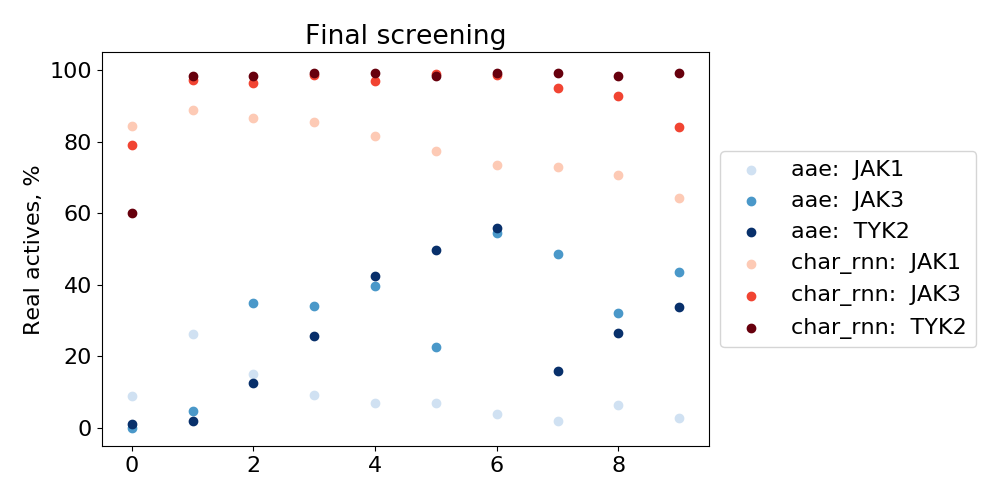

In [33]:
import matplotlib
metric_df = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'metrics-class-vsjak2-neigh1x05-allseed.csv'))
metric_df['target'] = [it.split(':')[1] for it in metric_df.Model.tolist()]
metric_df['Model'] = [it.split(':')[0] for it in metric_df.Model.tolist()]
d= metric_df.groupby(['target', 'Model'])['Real_actives'].apply(list).unstack(level='Model')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
plt.close()
f, ax = plt.subplots(figsize=(10,5),sharey=True)

idx = d.index
colors = [plt.cm.Blues(np.linspace(0.2,1,len(idx))),plt.cm.Reds(np.linspace(0.2,1,len(idx)))]


ax.set_ylabel('Real actives, %')
n_actives = [883 ,299 ,114 ]
for j,col in enumerate(d.columns):
  for i,target in enumerate(idx):
    x = np.array(range(len(d[col][target])))
    ax.scatter(x, np.array(d[col][target])*100, color=colors[j][i],label=str(col)+': '+str(target))#n_actives[i]
    ax.set_title('Final screening')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#ax.set_ylim(-0.1,1)
plt.tight_layout()
display(plt.show())

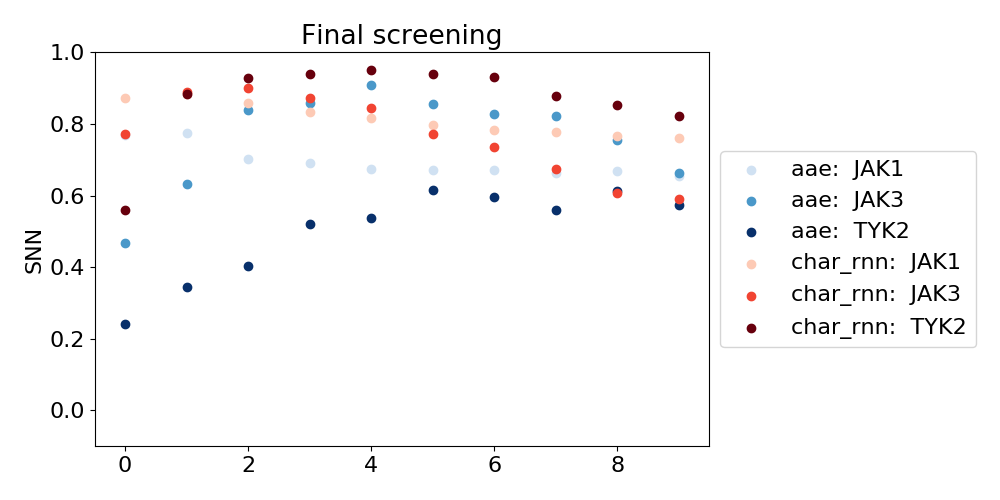

In [34]:
d= metric_df.groupby(['target', 'Model'])['SNN/Test'].apply(list).unstack(level='Model')
matplotlib.rc('font', **font)
plt.close()
f, ax = plt.subplots(figsize=(10,5),sharey=True)

idx = d.index
colors = [plt.cm.Blues(np.linspace(0.2,1,len(idx))),plt.cm.Reds(np.linspace(0.2,1,len(idx)))]


ax.set_ylabel('SNN')
for j,col in enumerate(d.columns):
  for i,target in enumerate(idx):
    x = np.array(range(len(d[col][target])))
    ax.scatter(x, np.array(d[col][target]), color=colors[j][i],label=str(col)+': '+str(target))
    #ax.set_title('SNN')
    ax.set_title('Final screening')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-0.1,1)
plt.tight_layout()
display(plt.show())

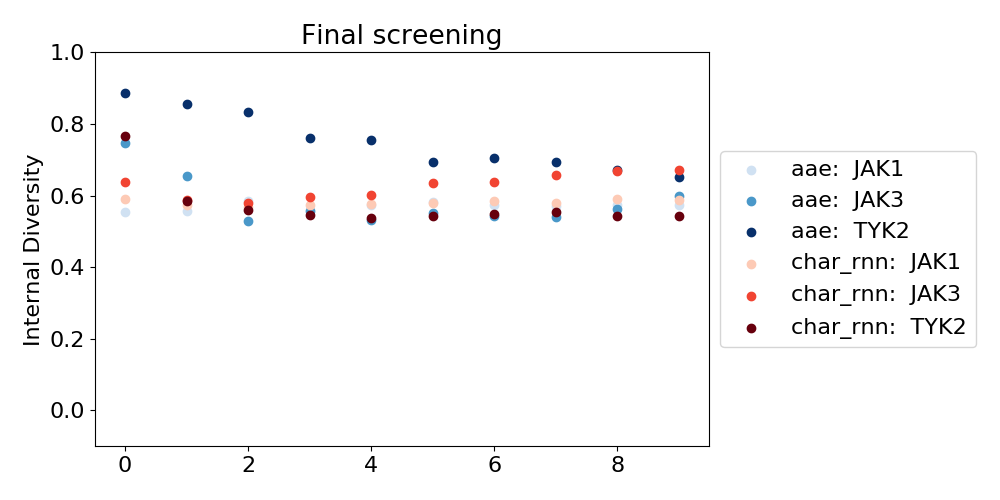

In [35]:
d = metric_df.groupby(['target', 'Model'])['IntDiv'].apply(list).unstack(level='Model')
plt.close()
f, ax = plt.subplots(figsize=(10,5),sharey=True)

idx = d.index
colors = [plt.cm.Blues(np.linspace(0.2,1,len(idx))),plt.cm.Reds(np.linspace(0.2,1,len(idx)))]


ax.set_ylabel('Internal Diversity')
#ax.set_xlabel('Iterations')

for j,col in enumerate(d.columns):
  for i,target in enumerate(idx):
    x = np.array(range(len(d[col][target])))
    ax.scatter(x, np.array(d[col][target]), color=colors[j][i],label=str(col)+': '+str(target))
    #ax.set_title('SNN')
    ax.set_title('Final screening')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
from matplotlib.ticker import FormatStrFormatter

ax.set_ylim(-0.1,1)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout()
display(plt.show())

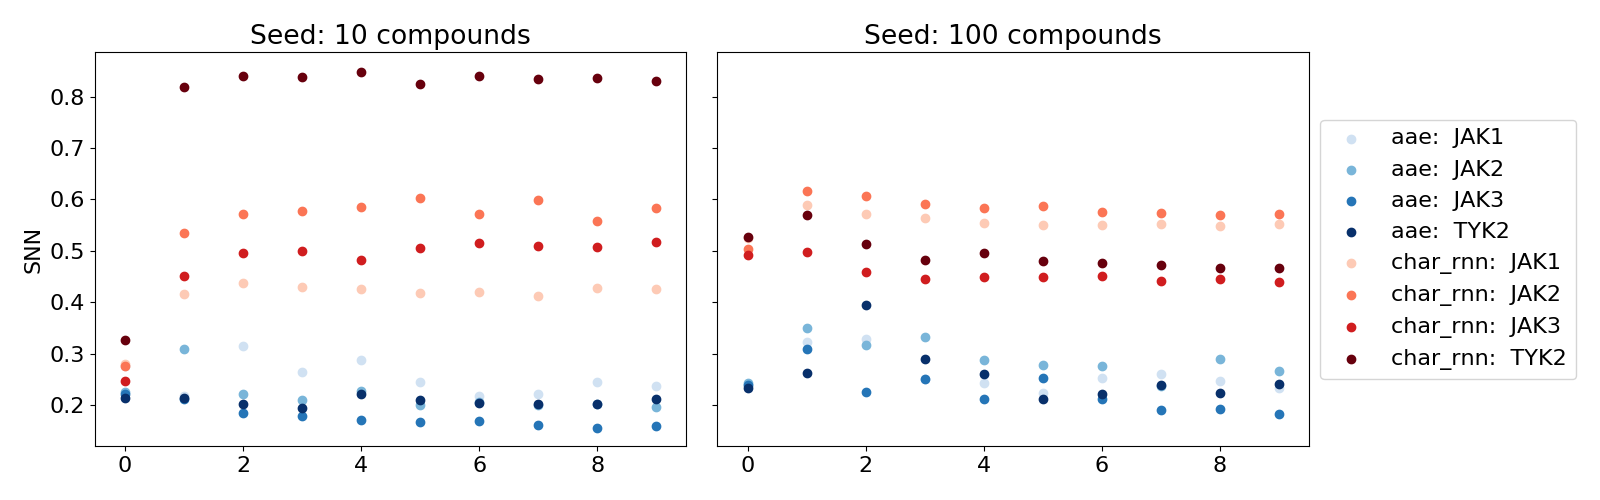

In [36]:

d100= metric_df.groupby(['target', 'Model'])['SNN/Test'].apply(list).unstack(level='Model')
d10 = seed10.groupby(['target', 'Model'])['SNN/Test'].apply(list).unstack(level='Model')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
plt.close()
f, axes = plt.subplots(figsize=(16,5),ncols = 2,sharey=True)

idx = d.index
colors = [plt.cm.Blues(np.linspace(0.2,1,len(idx))),plt.cm.Reds(np.linspace(0.2,1,len(idx)))]
for k, ax in enumerate(axes):
  d = [d10,d100][k]
  if k ==0:
    ax.set_ylabel('SNN')
  for j,col in enumerate(d.columns):
    for i,target in enumerate(idx):
      x = np.array(range(len(d[col][target])))
      

      ax.scatter(x, np.array(d[col][target]), color=colors[j][i],label=str(col)+': '+str(target))
      ax.set_title('Seed: '+['10','100'][k]+' compounds')
      #plt.plot(x, sigmoid(x, *popt), color=colors[j][i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
display(plt.show())

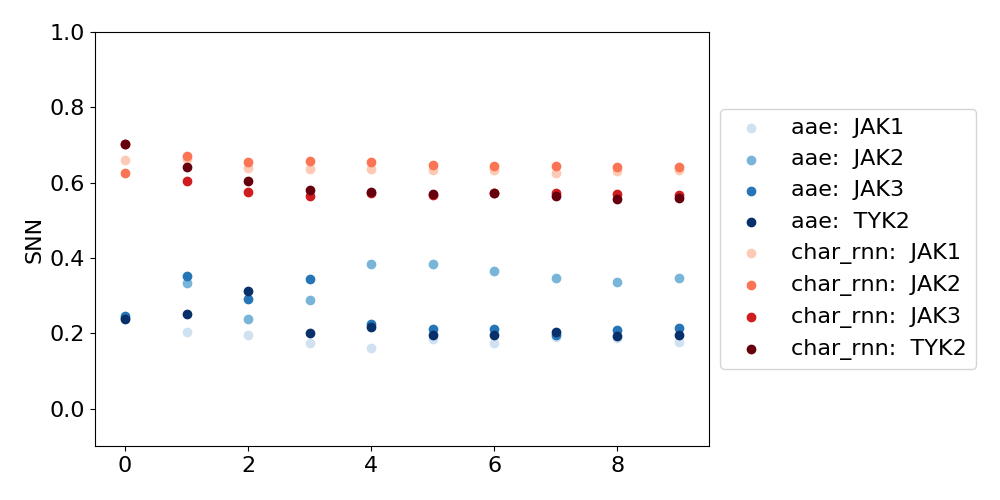

In [37]:
d= metric_df.groupby(['target', 'Model'])['SNN/Test'].apply(list).unstack(level='Model')
matplotlib.rc('font', **font)
plt.close()
f, ax = plt.subplots(figsize=(10,5),sharey=True)

idx = d.index
colors = [plt.cm.Blues(np.linspace(0.2,1,len(idx))),plt.cm.Reds(np.linspace(0.2,1,len(idx)))]


ax.set_ylabel('SNN')
for j,col in enumerate(d.columns):
  for i,target in enumerate(idx):
    x = np.array(range(len(d[col][target])))
    ax.scatter(x, np.array(d[col][target]), color=colors[j][i],label=str(col)+': '+str(target))
    #ax.set_title('SNN')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-0.1,1)
plt.tight_layout()
display(plt.show())

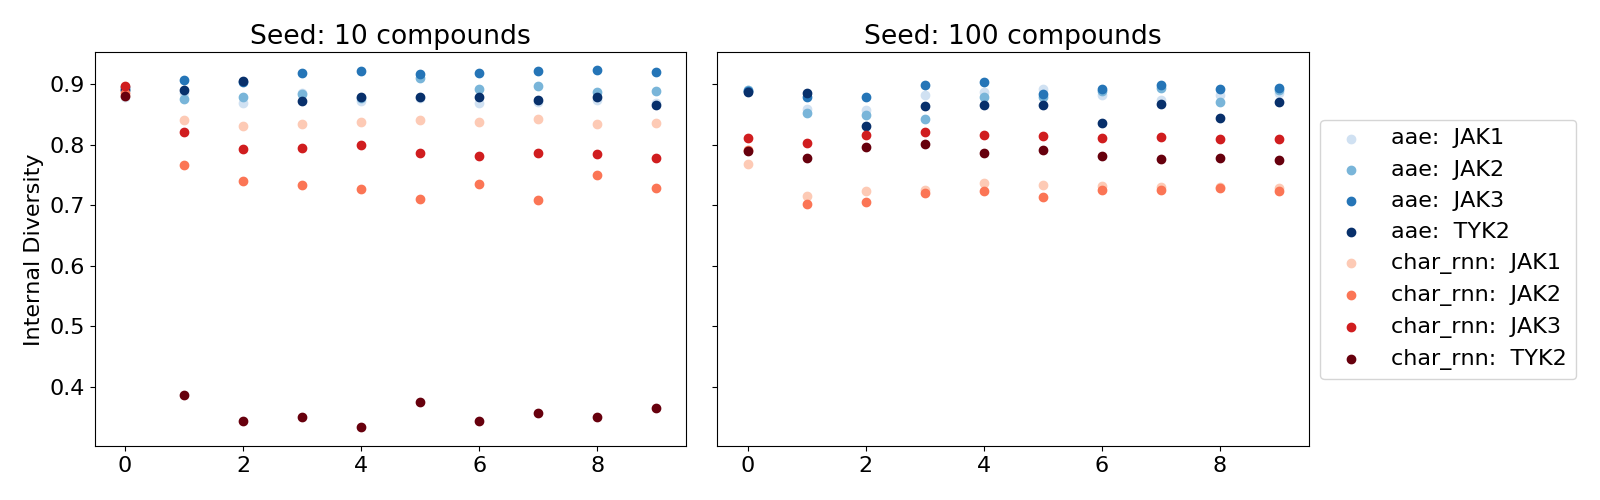

In [38]:
d100= metric_df.groupby(['target', 'Model'])['IntDiv'].apply(list).unstack(level='Model')
d10 = seed10.groupby(['target', 'Model'])['IntDiv'].apply(list).unstack(level='Model')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
plt.close()
f, axes = plt.subplots(figsize=(16,5),ncols = 2,sharey=True)

idx = d.index
colors = [plt.cm.Blues(np.linspace(0.2,1,len(idx))),plt.cm.Reds(np.linspace(0.2,1,len(idx)))]
for k, ax in enumerate(axes):
  d = [d10,d100][k]
  if k ==0:
    ax.set_ylabel('Internal Diversity')
  for j,col in enumerate(d.columns):
    for i,target in enumerate(idx):
      x = np.array(range(len(d[col][target])))
      

      ax.scatter(x, np.array(d[col][target]), color=colors[j][i],label=str(col)+': '+str(target))
      ax.set_title('Seed: '+['10','100'][k]+' compounds')
      #plt.plot(x, sigmoid(x, *popt), color=colors[j][i])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
display(plt.show())

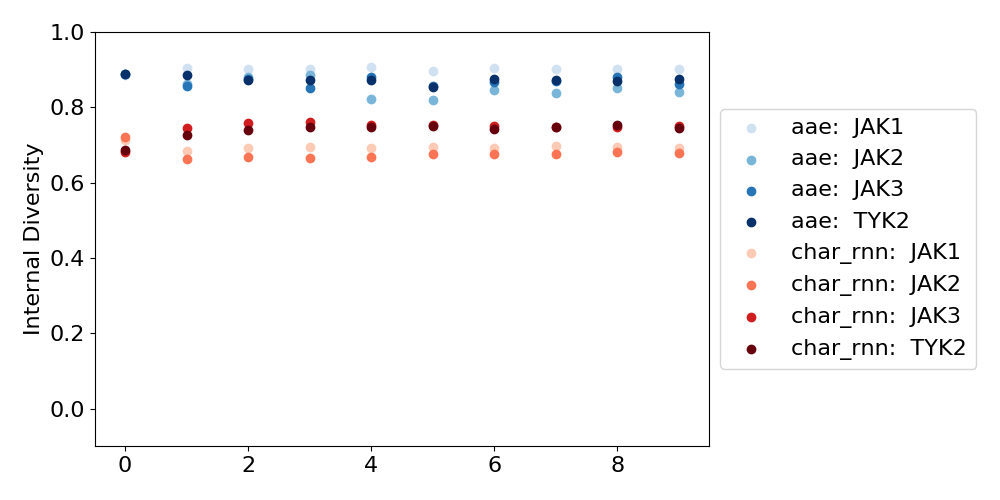

In [39]:
d = metric_df.groupby(['target', 'Model'])['IntDiv'].apply(list).unstack(level='Model')
plt.close()
f, ax = plt.subplots(figsize=(10,5),sharey=True)

idx = d.index
colors = [plt.cm.Blues(np.linspace(0.2,1,len(idx))),plt.cm.Reds(np.linspace(0.2,1,len(idx)))]


ax.set_ylabel('Internal Diversity')
#ax.set_xlabel('Iterations')

for j,col in enumerate(d.columns):
  for i,target in enumerate(idx):
    x = np.array(range(len(d[col][target])))
    ax.scatter(x, np.array(d[col][target]), color=colors[j][i],label=str(col)+': '+str(target))
    #ax.set_title('SNN')
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
from matplotlib.ticker import FormatStrFormatter

ax.set_ylim(-0.1,1)

ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout()
display(plt.show())

In [40]:
s100 = pd.melt(metric_df, id_vars = ['target','Model'],value_vars = ['Real_actives','SNN/Test','IntDiv'])
s100['seed'] = ['Seed - 100 compounds' for i in range(len(s100))]
s10 = pd.melt(seed10, id_vars = ['target','Model'],value_vars = ['Real_actives','SNN/Test','IntDiv'])
s10['seed'] = ['Seed - 10 compounds' for i in range(len(s10))]
s = pd.concat([s10,s100])

In [41]:
metric_df['target'] = [it.split(':')[1] for it in metric_df.Model.tolist()]
metric_df['Model'] = [it.split(':')[0] for it in metric_df.Model.tolist()]
display(metric_df.head())

valid,unique@1000,FCD/Test,SNN/Test,Frag/Test,Scaf/Test,IntDiv,IntDiv2,Filters,logP,SA,QED,NP,weight,Model,Iteration,Frac_actives,Real_actives,target
0.35429999999999995,1.0,33.515425238762546,0.23835806652899352,0.5470639676065269,0.06589355737163627,0.8902504309915522,0.8807485298088286,0.5893310753598645,0.4030606854482426,0.47787191176770083,7.644890287625272E-5,0.3404411314290937,20432.35280742945,aae,0,0.11086036671368124,0.0,JAK1
0.3849,0.994,24.909736878492552,0.3236428482303622,0.844695274248866,0.13197002821603898,0.858348723063001,0.8407201189595954,0.6435437776045726,0.6142313639845232,0.3532631019110637,0.0037741773486028446,0.27565756496429245,8663.341834903531,aae,1,0.34352755075138414,0.002285714285714286,JAK1
0.786,0.988,25.59006824186793,0.3277835317998745,0.7701313672708489,0.23247102577406298,0.8575736711975044,0.8349333396166885,0.6623409669211195,0.32437878028854383,0.25882396331996727,1.1019332325108017E-4,0.93345763423703,20598.013025077053,aae,2,0.4597894736842105,0.012571428571428572,JAK1
0.6377999999999999,1.0,32.025664639435504,0.24997746335344279,0.6335037112294809,0.07832591412945,0.8815967220745143,0.8711007232143939,0.4147068046409533,1.0105064587973223,0.48599509979186895,0.021330396550519028,0.8644023049678684,7312.795518970324,aae,3,0.5043914680050188,0.001142857142857143,JAK1
0.7719,0.999,32.49170782596934,0.24267179544226988,0.500853053078252,0.04983756786221094,0.8869958257857296,0.8742278891192632,0.5582329317269076,1.610979113130366,0.327157272689103,0.006596751831111712,0.8364529965193799,16664.480051671366,aae,4,0.46563394949231973,0.001142857142857143,JAK1


# unused material

In [43]:
import re
import pandas as pd 
import matplotlib.pyplot as plt
jtnn_loss = pd.read_csv('/dbfs/FileStore/g2g/models/dpEC1-all_pairs-JAK1/log.csv')
jtnn_loss['loss'] = [float(''.join(re.findall("\d+\.\d+", item))) for item in jtnn_loss['loss']]
plt.close()
plt.subplot(121)
plt.plot(jtnn_loss.loss, label = 'loss')
plt.legend()
plt.subplot(122)
plt.plot(jtnn_loss.kl_div, label = 'kl_div')
plt.legend()
display(plt.show())

In [44]:

exp_all = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all-1825.csv')).filter(['smiles'])
aae_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'aae-13t09-filt-train-iter5.smi'))
char_rnn_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'char_rnn-13t09-filt-train-iter5.smi'))
X_train = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all-1825.csv')).smiles.tolist()
model_smiles = {}
model_smiles['aae'] = aae_all.SMILES.tolist()
model_smiles['char_rnn'] = char_rnn_all.SMILES.tolist()
plot_pca(models, X_train, model_smiles)

In [45]:
aae_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'aae-13t09-filt-train-iter5x10.smi'))
char_rnn_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'char_rnn-13t09-filt-train-iter5x10.smi'))
X_train = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all-1825.csv')).smiles.tolist()
model_smiles = {}
model_smiles['aae'] = aae_all.SMILES.tolist()
model_smiles['char_rnn'] = char_rnn_all.SMILES.tolist()
plot_pca(models, X_train, model_smiles)

In [46]:
aae_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'aae-13t09-filt-train-iter5x10e50.smi'))
char_rnn_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'char_rnn-13t09-filt-train-iter5x10e50.smi'))
X_train = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all-1825.csv')).smiles.tolist()
model_smiles = {}
model_smiles['aae'] = aae_all.SMILES.tolist()
model_smiles['char_rnn'] = char_rnn_all.SMILES.tolist()
plot_pca(models, X_train, model_smiles)

In [47]:
aae_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'aae-13t09-filt-train-iter5x10e50seedTest.smi'))
char_rnn_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'char_rnn-13t09-filt-train-iter5x10e50seedTest.smi'))
X_train = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all-1825.csv')).smiles.tolist()
model_smiles = {}
model_smiles['aae'] = aae_all.SMILES.tolist()
model_smiles['char_rnn'] = char_rnn_all.SMILES.tolist()
plot_pca(models, X_train, model_smiles)

In [48]:
aae_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'aae-13t09-filt-train_vsJAK1-iter9x10e50seedTest-10actives.smi'))
char_rnn_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'char_rnn-13t09-filt-train_vsJAK1-iter9x10e50seedTest-10actives.smi'))
X_train = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all-1825.csv')).smiles.tolist()
model_smiles = {}
model_smiles['aae'] = aae_all.SMILES.tolist()
model_smiles['char_rnn'] = char_rnn_all.SMILES.tolist()
plot_pca(models, X_train, model_smiles)

In [49]:
aae_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'aae-13t09-filt-train_vsJAK1-iter9x10e50seedTest-10actives.smi'))
char_rnn_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'char_rnn-13t09-filt-train_vsJAK1-iter9x10e50seedTest-10actives.smi'))
X_train = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all-1825.csv')).smiles.tolist()
model_smiles = {}
model_smiles['aae'] = aae_all.SMILES.tolist()
model_smiles['char_rnn'] = char_rnn_all.SMILES.tolist()
plot_pca(models, X_train, model_smiles)

In [50]:
aae_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'aae-13t09-filt-train_vsJAK1-iter9x10e50seedTest-10actives-uniq.smi'))
char_rnn_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'char_rnn-13t09-filt-train_vsJAK1-iter9x10e50seedTest-10actives-uniq.smi'))
X_train = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all-1825.csv')).smiles.tolist()
model_smiles = {}
model_smiles['aae'] = aae_all.SMILES.tolist()
model_smiles['char_rnn'] = char_rnn_all.SMILES.tolist()
plot_pca(models, X_train, model_smiles)

In [51]:
aae_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'aae-13t09-filt-train_vsJAK1-iter9x10e50seedTest-100actives-uniq.smi'))
char_rnn_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'char_rnn-13t09-filt-train_vsJAK1-iter9x10e50seedTest-100actives-uniq.smi'))
X_train = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all-1825.csv')).smiles.tolist()
model_smiles = {}
model_smiles['aae'] = aae_all.SMILES.tolist()
model_smiles['char_rnn'] = char_rnn_all.SMILES.tolist()
plot_pca(models, X_train, model_smiles)

In [52]:
aae_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'aae-13t09-filt-train_vsJAK1-iter9x10e50seedTest-sim03-100actives-uniq.smi'))
char_rnn_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'char_rnn-13t09-filt-train_vsJAK1-iter9x10e50seedTest-sim03-100actives-uniq.smi'))
X_train = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all-1825.csv')).smiles.tolist()
model_smiles = {}
model_smiles['aae'] = aae_all.SMILES.tolist()
model_smiles['char_rnn'] = char_rnn_all.SMILES.tolist()
plot_pca(models, X_train, model_smiles)


In [53]:
aae_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'aae-13t09-filt-train_vsJAK1-iter9x10e50seedTest-prob08-100actives-uniq.smi'))
char_rnn_all = pd.read_csv(os.path.join(VIRTUAL_SCREENING,'char_rnn-13t09-filt-train_vsJAK1-iter9x10e50seedTest-prob08-100actives-uniq.smi'))
X_train = pd.read_csv(os.path.join(CHEMPROP_DIR,'JAK','all-1825.csv')).smiles.tolist()
model_smiles = {}
model_smiles['aae'] = aae_all.SMILES.tolist()
model_smiles['char_rnn'] = char_rnn_all.SMILES.tolist()
plot_pca(models, X_train, model_smiles)


# MOSES neural nets

In [55]:
# Initial library generation


n_samples = '100000'

for model in models:
  model_load = os.path.join(ZINC_Models,model+'-13t09-filt.model')
  config_load = os.path.join(ZINC_Models,model+'-13t09-filt.config')
  vocab_load = os.path.join(ZINC_Models,model+'-13t09-filt.vocab')
  gen_save = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt_gen100000.smi')

  MODELS = ModelsStorage()
  gen_parser = moses_parser_generate()
  config = gen_parser.parse_args([model,'--model_load',model_load,
                                  '--config_load',config_load,
                                  '--vocab_load',vocab_load,
                                  '--n_samples',n_samples,
                                  '--gen_save',gen_save])

  moses_generate(model,config)

Generating samples: 0%| | 0/100000 [00:00<?, ?it/s]Generating samples: 0%| | 32/100000 [00:00<06:36, 251.95it/s]Generating samples: 0%| | 64/100000 [00:00<06:35, 252.90it/s]Generating samples: 0%| | 96/100000 [00:00<06:33, 253.62it/s]Generating samples: 0%| | 128/100000 [00:00<06:33, 253.56it/s]Generating samples: 0%| | 160/100000 [00:00<06:33, 253.75it/s]Generating samples: 0%| | 192/100000 [00:00<06:33, 253.64it/s]Generating samples: 0%| | 224/100000 [00:00<06:46, 245.37it/s]Generating samples: 0%| | 256/100000 [00:01<06:48, 244.06it/s]Generating samples: 0%| | 288/100000 [00:01<06:52, 241.50it/s]Generating samples: 0%| | 320/100000 [00:01<06:46, 245.16it/s]Generating samples: 0%| | 352/100000 [00:01<06:42, 247.30it/s]Generating samples: 0%| | 384/100000 [00:01<06:39, 249.41it/s]Generating samples: 0%| | 416/100000 [00:01<06:37, 250.54it/s]Generating samples: 0%| | 448/100000 [00:01<06:35, 251.68it/s]Generating samples: 0%| | 480/100000 [00:01<06:33, 252.62it/s]Generating samples: 1%| | 512/100000 [00:02<06:32, 253.22it/s]Generating samples: 1%| | 544/100000 [00:02<06:32, 253.15it/s]Generating samples: 1%| | 576/100000 [00:02<06:31, 253.82it/s]Generating samples: 1%| | 608/100000 [00:02<06:30, 254.42it/s]Generating samples: 1%| | 640/100000 [00:02<06:30, 254.20it/s]Generating samples: 1%| | 672/100000 [00:02<06:32, 253.10it/s]Generating samples: 1%| | 704/100000 [00:02<06:31, 253.44it/s]Generating samples: 1%| | 736/100000 [00:02<06:32, 253.10it/s]Generating samples: 1%| | 768/100000 [00:03<06:32, 252.86it/s]Generating samples: 1%| | 800/100000 [00:03<06:37, 249.64it/s]Generating samples: 1%| | 832/100000 [00:03<06:34, 251.14it/s]Generating samples: 1%| | 864/100000 [00:03<06:32, 252.29it/s]Generating samples: 1%| | 896/100000 [00:03<06:31, 252.89it/s]Generating samples: 1%| | 928/100000 [00:03<06:32, 252.19it/s]Generating samples: 1%| | 960/100000 [00:03<06:31, 253.13it/s]Generating samples: 1%| | 992/100000 [00:03<06:30, 253.53it/s]Generating samples: 1%| | 1024/100000 [00:04<06:30, 253.70it/s]Generating samples: 1%| | 1056/100000 [00:04<06:32, 252.30it/s]Generating samples: 1%| | 1088/100000 [00:04<06:31, 252.88it/s]Generating samples: 1%| | 1120/100000 [00:04<06:30, 253.37it/s]Generating samples: 1%| | 1152/100000 [00:04<06:29, 253.93it/s]Generating samples: 1%| | 1184/100000 [00:04<06:30, 253.17it/s]Generating samples: 1%| | 1216/100000 [00:04<06:29, 253.92it/s]Generating samples: 1%| | 1248/100000 [00:04<06:29, 253.28it/s]Generating samples: 1%|▏ | 1280/100000 [00:05<06:31, 252.29it/s]Generating samples: 1%|▏ | 1312/100000 [00:05<06:30, 252.91it/s]Generating samples: 1%|▏ | 1344/100000 [00:05<06:29, 253.51it/s]Generating samples: 1%|▏ | 1376/100000 [00:05<06:28, 253.79it/s]Generating samples: 1%|▏ | 1408/100000 [00:05<06:32, 251.43it/s]Generating samples: 1%|▏ | 1440/100000 [00:05<06:30, 252.09it/s]Generating samples: 1%|▏ | 1472/100000 [00:05<06:29, 253.22it/s]Generating samples: 2%|▏ | 1504/100000 [00:05<06:36, 248.35it/s]Generating samples: 2%|▏ | 1536/100000 [00:06<06:35, 248.85it/s]Generating samples: 2%|▏ | 1568/100000 [00:06<06:33, 250.42it/s]Generating samples: 2%|▏ | 1600/100000 [00:06<06:30, 251.94it/s]Generating samples: 2%|▏ | 1632/100000 [00:06<06:28, 252.99it/s]Generating samples: 2%|▏ | 1664/100000 [00:06<06:32, 250.55it/s]Generating samples: 2%|▏ | 1696/100000 [00:06<06:31, 251.01it/s]Generating samples: 2%|▏ | 1728/100000 [00:06<06:29, 252.15it/s]Generating samples: 2%|▏ | 1760/100000 [00:06<06:34, 248.75it/s]Generating samples: 2%|▏ | 1792/100000 [00:07<06:33, 249.60it/s]Generating samples: 2%|▏ | 1824/100000 [00:07<06:31, 250.56it/s]Generating samples: 2%|▏ | 1856/100000 [00:07<06:29, 251.99it/s]Generating samples: 2%|▏ | 1888/100000 [00:07<06:30, 251.20it/s]Generating samples: 2%|▏ | 1920/100000 [00:07<06:29, 251.92it/s]Generating samples: 2%|▏ | 1952/100000 [00:07<06:27, 252.82it/s]Generating samples: 2%|▏ | 1984/100000 [00:07<06:26, 253

In [56]:
for model in models[1:]:
  #adding SLogP
  from mordred import SLogP, Calculator
  #features_path = os.path.join(VIRTUAL_SCREENING,model+name)
  descriptor = SLogP.SLogP()
  df = pd.read_csv(os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt_gen100000.smi'))
  test_path = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt_gen100000-uniq.smi')
  features_path = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt_gen100000-uniq.txt')

  calculate_feature(descriptor = descriptor, df=df,out_feat=features_path,out_smi=test_path)

Generated: 100000
Unique: 57118
/local_disk0/tmp/1557585063317-0/PythonShell.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 import traceback
Molecules: 56593
Valid Molecules: 56593

In [57]:
for model in models:
  #prediction
  test_path = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt_gen100000-uniq.smi')
  preds_path = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt_gen100000-preds.csv')
  checkpoint_path = os.path.join(VIRTUAL_SCREENING,'Chemprop-Feat_SLogP','fold_0/model_0/model.pt')
  features_path = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt_gen100000-uniq.txt')

  pred_parser = ArgumentParser()
  add_predict_args(pred_parser)
  args = pred_parser.parse_args(['--test_path',test_path,
                                 '--checkpoint_path',checkpoint_path,
                                 '--preds_path',preds_path,
                                 '--features_path',features_path,
                                ])

  modify_predict_args(args)
  make_predictions(args)

Loading training args
Loading data
 0%| | 0/62597 [00:00<?, ?it/s] 1%| | 690/62597 [00:00<00:08, 6897.41it/s] 2%|▏ | 1379/62597 [00:00<00:08, 6893.11it/s] 3%|▎ | 2064/62597 [00:00<00:08, 6879.03it/s] 4%|▍ | 2751/62597 [00:00<00:08, 6873.13it/s] 5%|▌ | 3441/62597 [00:00<00:08, 6879.86it/s] 7%|▋ | 4134/62597 [00:00<00:08, 6893.71it/s] 8%|▊ | 4825/62597 [00:00<00:08, 6896.85it/s] 9%|▉ | 5503/62597 [00:00<00:08, 6860.63it/s] 10%|▉ | 6189/62597 [00:00<00:08, 6860.03it/s] 11%|█ | 6882/62597 [00:01<00:08, 6880.02it/s] 12%|█▏ | 7586/62597 [00:01<00:07, 6925.73it/s] 13%|█▎ | 8272/62597 [00:01<00:07, 6905.59it/s] 14%|█▍ | 8963/62597 [00:01<00:07, 6906.34it/s] 15%|█▌ | 9657/62597 [00:01<00:07, 6914.58it/s] 17%|█▋ | 10362/62597 [00:01<00:07, 6953.08it/s] 18%|█▊ | 11055/62597 [00:01<00:07, 6857.20it/s] 19%|█▉ | 11746/62597 [00:01<00:07, 6871.81it/s] 20%|█▉ | 12441/62597 [00:01<00:07, 6892.87it/s] 21%|██ | 13134/62597 [00:01<00:07, 6903.63it/s] 22%|██▏ | 13834/62597 [00:02<00:07, 6930.98it/s] 23%|██▎ | 14527/62597 [00:02<00:07, 6823.30it/s] 24%|██▍ | 15210/62597 [00:02<00:06, 6802.79it/s] 25%|██▌ | 15891/62597 [00:02<00:06, 6684.37it/s] 26%|██▋ | 16586/62597 [00:02<00:06, 6759.48it/s] 28%|██▊ | 17289/62597 [00:02<00:06, 6835.43it/s] 29%|██▊ | 17992/62597 [00:02<00:06, 6890.43it/s] 30%|██▉ | 18690/62597 [00:02<00:06, 6914.99it/s] 31%|███ | 19387/62597 [00:02<00:06, 6928.49it/s] 32%|███▏ | 20081/62597 [00:02<00:06, 6890.05it/s] 33%|███▎ | 20771/62597 [00:03<00:07, 5889.78it/s] 34%|███▍ | 21453/62597 [00:03<00:06, 6139.69it/s] 35%|███▌ | 22150/62597 [00:03<00:06, 6367.22it/s] 36%|███▋ | 22833/62597 [00:03<00:06, 6497.18it/s] 38%|███▊ | 23528/62597 [00:03<00:05, 6625.64it/s] 39%|███▊ | 24226/62597 [00:03<00:05, 6726.47it/s] 40%|███▉ | 24920/62597 [00:03<00:05, 6786.94it/s] 41%|████ | 25621/62597 [00:03<00:05, 6851.70it/s] 42%|████▏ | 26310/62597 [00:03<00:05, 6856.00it/s] 43%|████▎ | 27000/62597 [00:03<00:05, 6867.97it/s] 44%|████▍ | 27689/62597 [00:04<00:05, 6714.74it/s] 45%|████▌ | 28381/62597 [00:04<00:05, 6774.71it/s] 46%|████▋ | 29083/62597 [00:04<00:04, 6845.45it/s] 48%|████▊ | 29784/62597 [00:04<00:04, 6891.79it/s] 49%|████▊ | 30486/62597 [00:04<00:04, 6926.96it/s] 50%|████▉ | 31187/62597 [00:04<00:04, 6950.29it/s] 51%|█████ | 31885/62597 [00:04<00:04, 6957.74it/s] 52%|█████▏ | 32584/62597 [00:04<00:04, 6966.73it/s] 53%|█████▎ | 33281/62597 [00:04<00:04, 6955.96it/s] 54%|█████▍ | 33977/62597 [00:04<00:04, 6954.67it/s] 55%|█████▌ | 34677/62597 [00:05<00:04, 6968.01it/s] 57%|█████▋ | 35374/62597 [00:05<00:03, 6963.77it/s] 58%|█████▊ | 36072/62597 [00:05<00:03, 6967.67it/s] 59%|█████▊ | 36769/62597 [00:05<00:03, 6946.32it/s] 60%|█████▉ | 37470/62597 [00:05<00:03, 6964.65it/s] 61%|██████ | 38174/62597 [00:05<00:03, 6985.90it/s] 62%|██████▏ | 38873/62597 [00:05<00:03, 6958.30it/s] 63%|██████▎ | 39569/62597 [00:05<00:03, 6912.33it/s] 64%|██████▍ | 40261/62597 [00:05<00:03, 6907.91it/s] 65%|██████▌ | 40959/62597 [00:05<00:03, 6928.27it/s] 67%|██████▋ | 41660/62597 [00:06<00:03, 6950.48it/s] 68%|██████▊ | 42363/62597 [00:06<00:02, 6972.29it/s] 69%|██████▉ | 43064/62597 [00:06<00:02, 6982.87it/s] 70%|██████▉ | 43763/62597 [00:06<00:02, 6941.17it/s] 71%|███████ | 44470/62597 [00:06<00:02, 6978.91it/s] 72%|███████▏ | 45178/62597 [00:06<00:02, 7006.24it/s] 73%|███████▎ | 45879/62597 [00:06<00:02, 6923.77it/s] 74%|███████▍ | 46577/62597 [00:06<00:02, 6938.77it/s] 76%|███████▌ | 47277/62597 [00:06<00:02, 6956.18it/s] 77%|███████▋ | 47984/62597 [00:06<00:02, 6989.88it/s] 78%|███████▊ | 48687/62597 [00:07<00:01, 7001.08it/s] 79%|███████▉ | 49388/62597 [00:07<00:01, 6994.68it/s] 80%|████████ | 50088/62597 [00:07<00:01, 6991.76it/s] 81%|████████ | 50788/62597 [00:07<00:01, 6951.94it/s] 82%|████████▏ | 51484/62597 [00:07<00:01, 5762.56it/s] 83%|████████▎ | 52175/62597 [00:07<00:01, 6062.96it/s] 84%|████████▍ | 52869/62597 [00:07<00:01, 6300.39it/s] 86%|████████▌ | 53566/62597 [00

In [58]:
f, axes = plt.subplots(4, 2, sharex = True, sharey=True, figsize=(20,12))
for j, name in enumerate(names):
  for i, model in enumerate(models):
    preds = pd.read_csv(os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt_gen100000-preds.csv'))
    axes[j][i].hist(preds[name],bins=30)
    axes[j][i].axvline(7.6, color='r', linestyle='dashed', linewidth=2)
    axes[j][i].set_title(str(model)+', pEC50 over 7.6: '+str(sum(preds[name]>7.6)))
    if i==0:
      axes[j][i].set_ylabel(names[j][:4])

f.tight_layout()
display(f)

In [59]:
for model in models:
  #filtering
  preds_path = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt_gen100000-preds.csv')
  preds = pd.read_csv(preds_path)
  preds = preds[pd.DataFrame(preds[names]>7.6).any(axis='columns')]
  train_load = os.path.join(VIRTUAL_SCREENING,model+'-13t09-filt-train-iter0.smi')
  print(str(model)+', pEC50 over 7.6: '+str(len(preds)))
  preds.smiles.to_csv(train_load, index=False, header=['SMILES'])

aae, pEC50 over 7.6: 428
char_rnn, pEC50 over 7.6: 679